# DynapSim Neuron Model

This tutorial provides an overview of Dynap-SE2 neuron & synapse simulation and surrogate gradient function implementation. We will investigate:

1. A theoretical overview of silicon synapse and membrane circuitry.
2. How to build an SNN with `DynapSim`.
3. A single neuron response to an ex poisson spike train stimulation
4. The surrogate gradient implementation, which can be used to train a network with backpropagation.

In [1]:
from IPython.display import Image


## Section 1 : Neuron Model

In this chapter, a behavioral investigation of silicon neuron and silicon synapse circuits presented.

For detailed analyses of the circuits, please refer to:

* Synapse Circuitry
  * C. Bartolozzi and G. Indiveri, "Synaptic Dynamics in Analog VLSI," in Neural Computation, vol. 19, no. 10, pp. 2581-2603, Oct. 2007, doi: 10.1162/neco.2007.19.10.2581.


* Neuron Membrane Circuitry
  * P. Livi and G. Indiveri, "A current-mode conductance-based silicon neuron for address-event neuromorphic systems," 2009 IEEE International Symposium on Circuits and Systems, 2009, pp. 2898-2901, doi: 10.1109/ISCAS.2009.5118408.


* Analysis of the Silicon Neuron and Synapse Circuits
  * E. Chicca, F. Stefanini, C. Bartolozzi and G. Indiveri, "Neuromorphic Electronic Circuits for Building Autonomous Cognitive Systems," in Proceedings of the IEEE, vol. 102, no. 9, pp. 1367-1388, Sept. 2014, doi: 10.1109/JPROC.2014.2313954.

Silicon neuron and synapse implementations form a basis for the realization of computational neural models through adjusting some bias voltages and currents.
The analysis presented in this chapter shows how the higher-level hyper-parameters relate to low-level device voltages and currents.
The simulator's job is to translate the behavioral dynamics of a computational neural setting into the VLSI parameters of the respective circuits.

### Section 1.1 : Silicon Synapse

In order to mimic integrating synaptic dynamics, Dynap-SE uses an analog sub-threshold differential pair integrator circuit introduced by Bartolozzi and Indiveri, 2007.

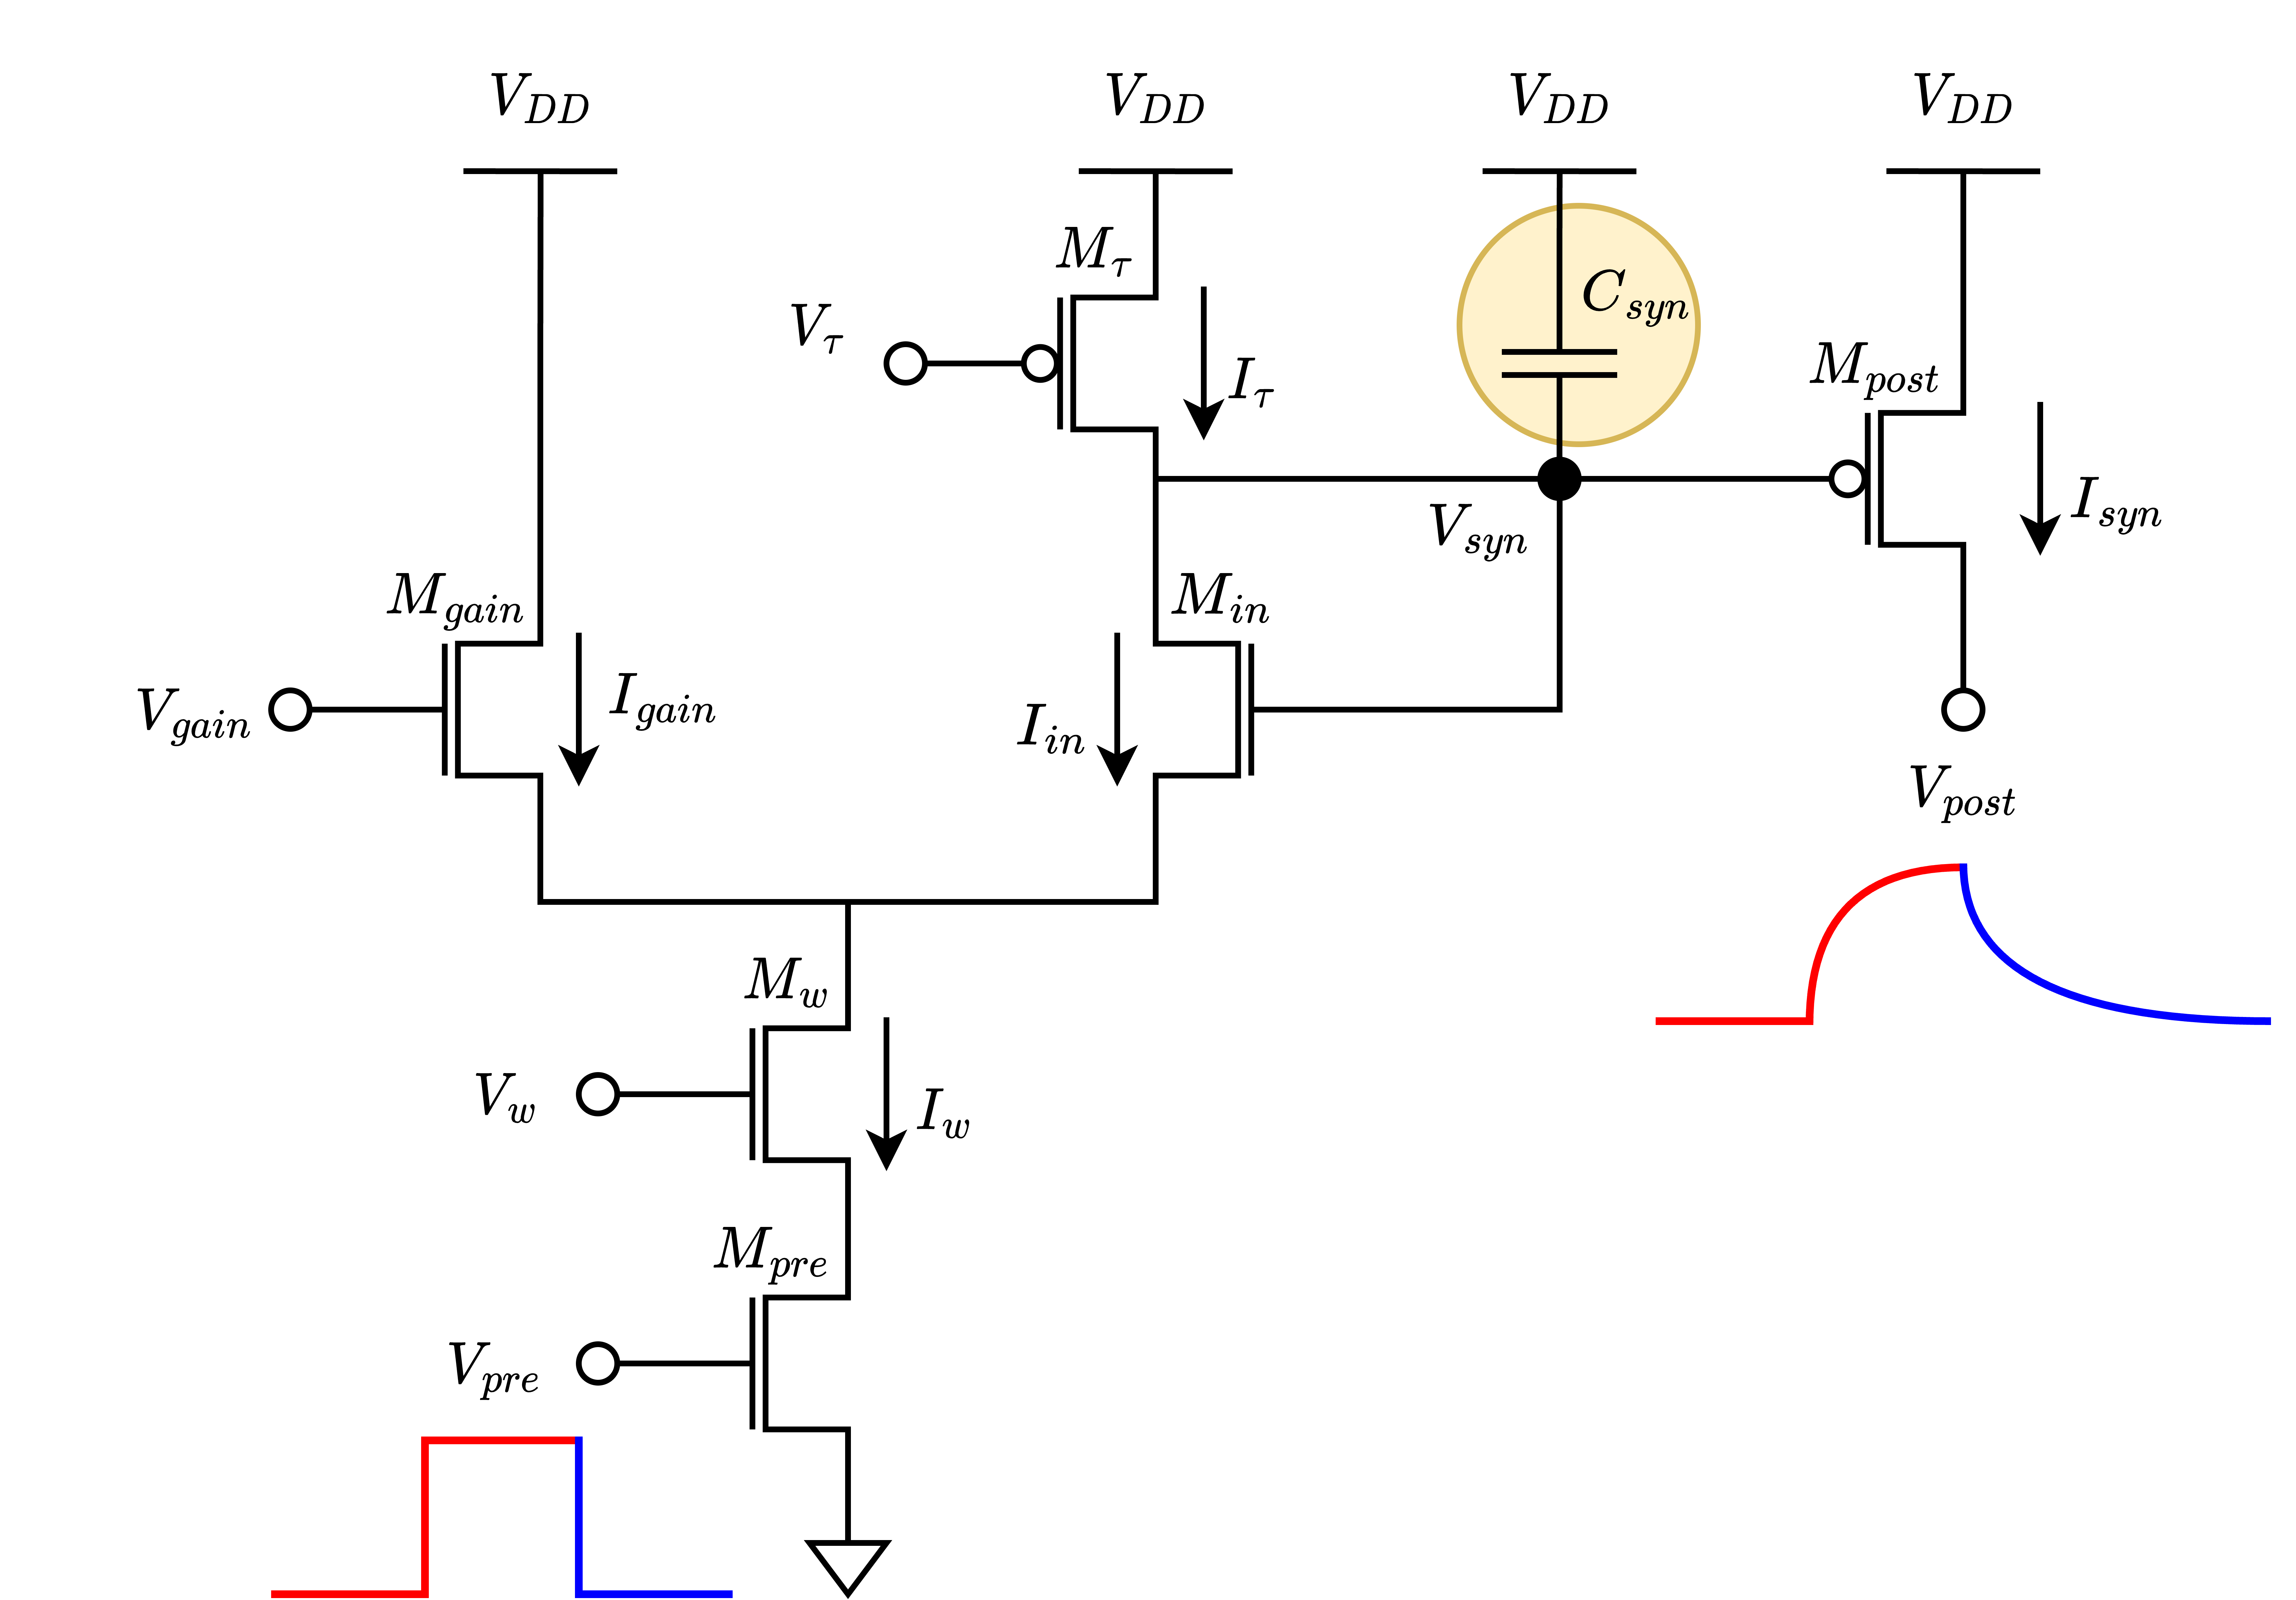

In [2]:
Image("images/silicon_synapse.png")


In principle, the circuit functions as a first-order linear RC filter with configurable exponential dynamics.
Inspiring from biology, the input node is named "pre-synaptic" and the output node is called "post-synaptic".
The circuitry responds to step input with exponentially increasing and decreasing output current dynamics, behaving like a proper RC filter.

$$
    \tau \left( 1 + \dfrac{I_{gain}}{I_{syn}}\right)\dfrac{d}{dt} I_{syn} + I_{syn} = \dfrac{I_{gain} I_w }{I_{\tau}} - I_{gain}
$$


The challange with this non-linear first order ODE is that it cannot be solved explicitly.
Instead the behavior can be treated partially, depending on the ratio between gain current $I_{gain}$ and state current $I_{syn}$.
$I_{gain}$ makes the circuit expresses short-term facilitation such that the pulses create less salient jumps in the output current $I_{syn}$ when $I_{syn}$ is sufficiently smaller than $I_{gain}$.
However, this effect diminishes when $I_{syn}$ is much bigger than $I_{gain}$, $I_{syn} >> I_{gain}$, and circuit start acting as a proper RC filter.
With this simplification, the step response of the circuit having low-pass filter equation.

$$
    I_{syn} (t) =
    \begin{cases}
        \dfrac{I_{gain} I_{w}}{I_{\tau}}\left( 1 - e^{-\frac{(t-t_i^-)}{\tau}} \right) + I_{syn}^{-} e^{-\frac{(t-t_i^-)}{\tau}} & \text{charge}    \\
        I_{syn}^{+} \cdot e^{-\frac{(t-t_i^+)}{\tau}}                                                                            & \text{discharge}
    \end{cases}
$$


Note that here the charge and discharge terms label the synaptic current charging instead of capacitor.
The synaptic current decreases, or leaks, exponentially with the same amount both at the charging and the discharging phase.
On the other hand, the synaptic current suddenly increases in the charging phase depending on the ratio between gain, synaptic weight, and leakage currents.
If the step input controlling the $I_{w}$ path is long enough, $I_{syn}$ reaches to its saturation point given in Equation above.

$$
    I_{syn_{\infty}} = \dfrac{I_{gain} I_{w}}{I_{\tau}}
$$

So, increasing $I_{gain}$ or $I_{w}$ results in increasing the amplitude of the post-synaptic potential.
Increasing ${I_{\tau}}$ results in decreasing amplitude.
However, the ${I_{\tau}}$ does not only takes part in the steady state current computation, but also sets the time constant.
The relation between leakage current ${I_{\tau}}$ and the time constant $\tau$ is given as

$$
    \tau = \dfrac{C_{syn}U_{T}}{\kappa I_{\tau}}
$$

Here the $\kappa$ stands for mean subthreshold factor (n-type, p-type) and the $U_T$ represents the thermal voltage which is around 25 mV in room temperature.
So, incresing $I_{\tau}$ results in decreasing time constant of the circuit.
Therefore the condition that changing $I_{\tau}$ changes both the time constant and the amplifier gain should be treated carefully.

All these are valid in the case that $I_{syn} >> I_{gain}$, otherwise, circuit does not behave as an RC filter.
Assuming that $I_{syn} << I_{gain}$, the equation simplifies to 

$$
    \tau \dfrac{d}{dt} I_{syn} + \dfrac{I_{syn}^{2}}{I_{gain}} - I_{syn} \left( \dfrac{I_{w}}{I_{\tau}} + 1 \right) = 0
$$


In this operation range, it's seen that the more the synaptic state current is the bigger jump it achieves.
Therefore, the first few spikes do not have a big impact on the synaptic state change.
Increasing the synaptic current, the effect of spikes starts being more prominent, similar to the short-term potentiation.

To recap, the differential pair integrator synapse emulates the behavior of biological synapses by integrating the events over time, increasing the post-synaptic potential.
The characteristic equation is not explicitly solvable, so it's partially studied with respect to the ratio between a parametric current $I_{gain}$, and the output state current $I_{syn}$.
The device has four types of synapse installation with slightly different capacitor values and silicon neuron interface.
Fast excitatory synapse AMPA, slow excitatory synapse NMDA, slow inhibitory synapse GABA, and fast inhibitory synapse SHUNT.
The following sections introduce the differences briefly.


#### Section 1.1.1 AMPA

Excitatory AMPA synapse gets its name from one of two main kinds of glutamate receptors found in the mammalian brains: AMPA and NMDA.
Even though they have much more complex dynamics and structure, the inspiration get from biological AMPA-type receptors is that they **can operate under weak stimulation and act fast creating short-lasting excitatory post synaptic potentiation (EPSP)**.
Therefore, the silicon AMPA synapse uses the same common synapse circuitry with a slightly smaller capacitance embedding.
It contributes to the injection current in an additive way in order to cause EPSP.


#### Section 1.1.2 NMDA

Excitatory NMDA synapse gets its name from the other popular glutamate receptor in biological synapses.
Different from AMPA, the carbon NMDA synapse requires more than just a weak stimulation.
The NMDA-type glutamate receptors can start operating after AMPA receptors depolarized the membrane sufficiently.
The inspiration that silicon NMDA gets from biology is that it mimics the voltage gating mechanism of the biological type.
In Figure below NMDA gating mechanism extending the common silicon synapse is provided.

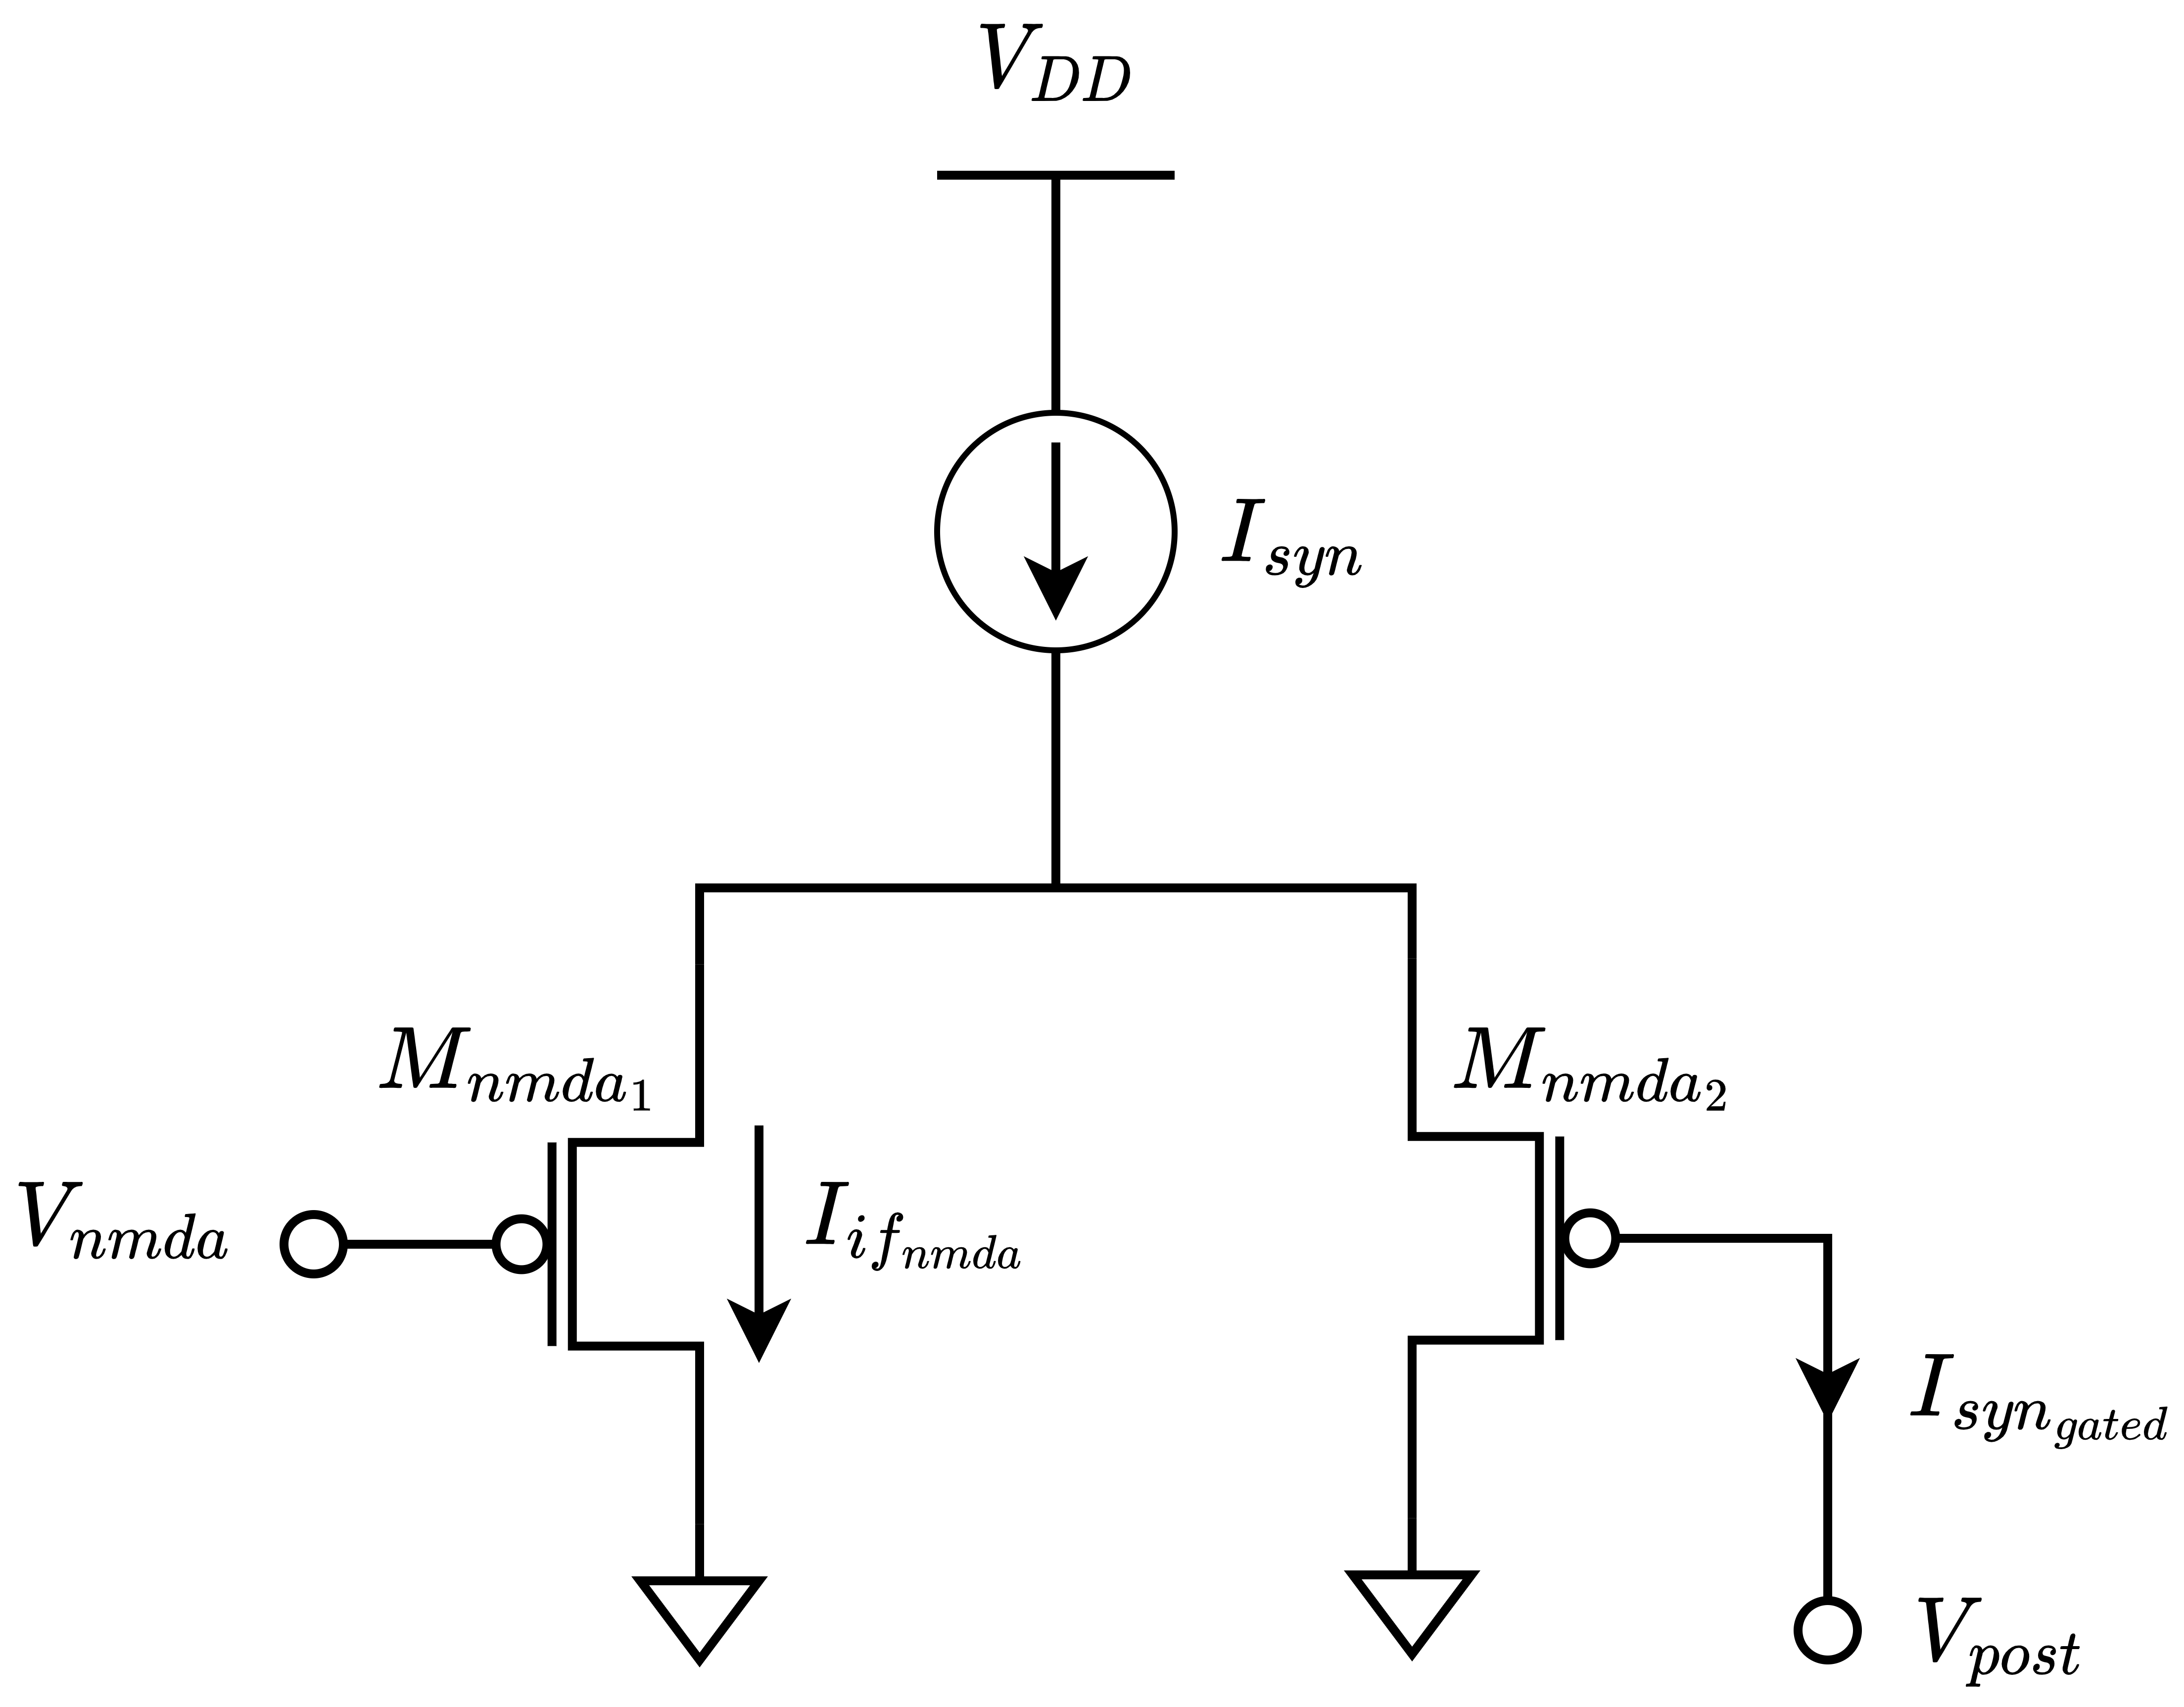

In [3]:
Image("images/nmda_gating.png", width=640)


Here the $I_{syn}$ current depicted as a current source is the output state current $I_{syn}$ of a silicon synapse circuit shown in the figure.
The comparator setting makes the NMDA state current flow through the circuit **only if the membrane potential of the post-synaptic side is greater than the gating voltage** $V_{post} > V_{nmda}$.
In the current domain, the behavoir can be explained in Equation below.

$$
    I_{syn_{gated}} = \dfrac{I_{syn}}{1 + \dfrac{I_{if_{nmda}}}{I_{mem}}}
$$

Here the $I_{mem}$ represents the membrane state current which is explained in detail in Silicon Neuron section.
The equation clarifies that the NMDA current can only contribute to the injection current significantly if the membrane state current $I_{mem}$ is much more greater then a configurable current value $I_{if_{nmda}}$.

Apart from the gating block, the silicon NMDA synapse uses the same common synapse circuitry with a slightly higher capacitance embedding.
Also, in the same way as AMPA, it contributes to the injection current in an additive way in order to cause EPSP.


#### Section 1.1.3 GABA

Inhibitory GABA synapse gets its name from the inhibitory neurotransmitter GABA.
There are two types of GABA receptors, namely GABAa and GABAb.
Even though they both create the same inhibitory effect making the neuron membrane less likely to fire, their way of achieving this is different.
The silicon GABA gets its inspiration from the GABAb receptor.
The way GABAb works is that when enough GABA binds, it releases the positive ions transported inside the membrane.
In this way, it reverts the excitatory synapses' depolarization outcome and decreases the membrane potential.
Based on the same idea, the silicon counterpart does **contribute to the leakage current, discharging the post-synaptic neuron's membrane capacitor**.
Therefore, it causes IPSP.


#### Section 1.1.4 SHUNT

The last synapse type is the fast inhibitory SHUNT synapse and it mimics the other GABA receptor GABAa.
GABAa does not cause the release of any positive ions passed in the membrane, instead, it let more negative ions pass through the membrane.
In this way, GABAa represses the effect of depolarization resulting from the increasing positive ion density.
The silicon counterpart SHUNT is named as is because it creates **a fast shunting effect**.
The SHUNT synapse subtractively contributes to the injection current causing IPSP.

### Section 1.2 Silicon Neuron

The DPI neuron (Livi & Indiveri 2009) is a VLSI interpretation of the AdExpIF(Adaptive Exponential Integrate and Fire) computational neuron model proposed by Brette, Gerstner in 2005.
This neuron model is capable of expressing complex temporal dynamics of a real neuron faithfully, by reproducing leaky input integration, both the positive feedback and negative feedback effects, and the refractory period.

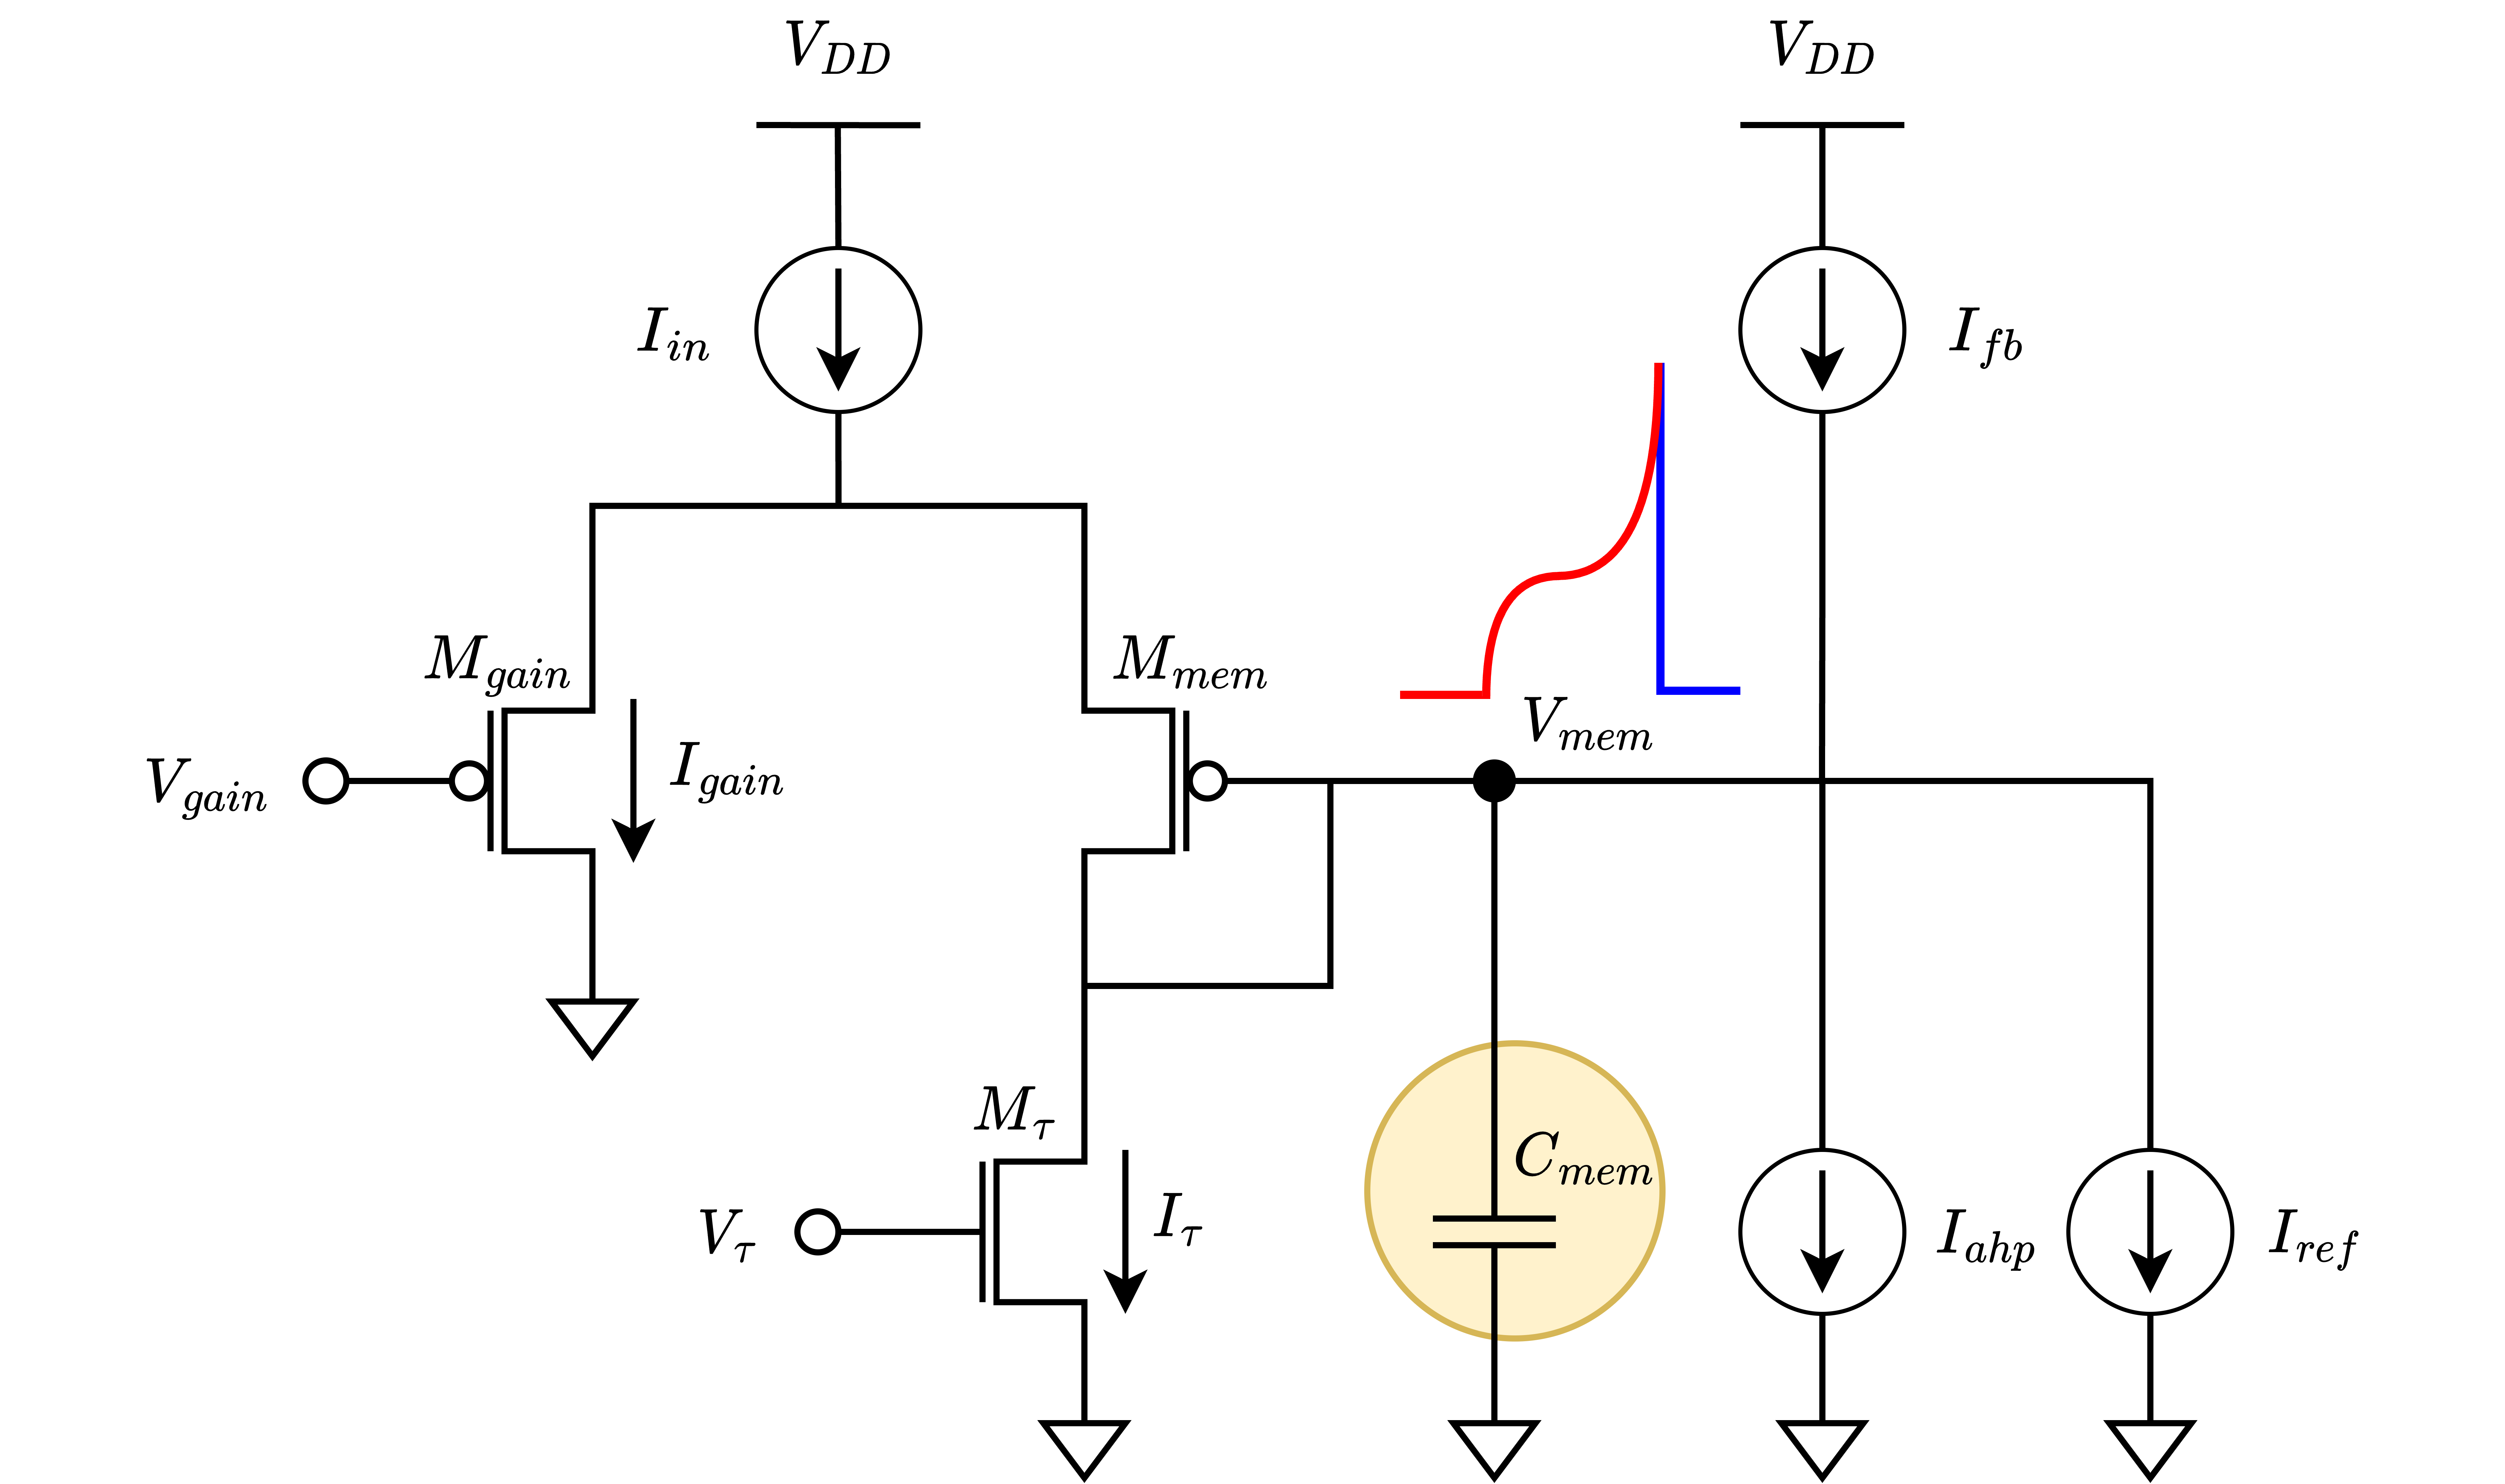

In [4]:
Image("images/silicon_neuron.png")


The circuit block emulates the leak conductance of a real neuron with tunable dynamic conductances.
It collects the pre-synaptic input currents coming from different sources and integrates them by means of charging a capacitor.

$$
    I_{in} = I_{dc} + I_{ampa} + I_{nmda} - I_{shunt}
$$

The GABA synapse does not directly contribute to the input current but contributes to the leakage current in such a way that it decreases the time constant.
Also, the AHP block drains current from the capacitor in the same way that $I_{\tau}$ and $I_{gaba}$ do.
Therefore, it's logical to group those currents in a virtual leakage term.
Thereby, the effective time constant that the circuit experiences instantaneously can be computed.
The virtual dynamical leakage current is expressed as in equation below.

$$
    I_{leak} = I_{\tau} + I_{ahp} + I_{gaba}
$$

In time constant computation, using the stateful leakage current in $I_{leak}$ equation provides a time-dependent time constant computation instead of using $I_{\tau}$ directly.
With this modification, the time constant can be computed as follows:

$$
    \tau = \dfrac{C_{mem}U_{T}}{\kappa I_{leak}}
$$

The building blocks of the silicon neuron circuit works in harmony and emulate the biological neural dynamics in subthreshold operation range.
The complete equation below describes this behavior in time domain, derived applying current mode analysis (Chicca, 2004).

$$
    \left( 1 + \dfrac{I_{gain}}{I_{mem}} \right) \tau \dfrac{d}{dt} I_{mem} + I_{mem} \left( 1 + \dfrac{I_{ahp}}{I_{\tau}} \right) = I_{mem_{\infty}} + f(I_{mem})
$$

| Component          | Formula                                                                        | Remark                        |
|--------------------|--------------------------------------------------------------------------------|-------------------------------|
| $\tau$             | $\dfrac{C_{mem}U_{T}}{\kappa I_{leak}}$                                        | Membrane time-constant        |
| $I_{leak}$         | $I_{\tau} + I_{ahp} + I_{gaba}$                                                | Effective leakage current     |
| $I_{mem_{\infty}}$ | $\dfrac{I_{gain}}{I_{\tau}} \left( I_{in}  - I_{leak}\right)$                  | Steady state membrane current |
| $f(I_{mem})$       | $\dfrac{I_{fb}}{I_{\tau}} \left(I_{mem} + I_{gain} \right)$                    | Positive feedback effect      |
| $I_{fb}$           | $I_{0} e^{\left(\frac{\kappa^2}{\kappa + 1} \cdot \frac{V_{mem}}{U_T}\right)}$ | Positivie feedback current    |
| $V_{mem}$          | $\dfrac{U_T}{\kappa} \cdot \ln \left(\dfrac{I_{mem}}{I_{0}}\right)$            | Membrane potential            |
| $I_{0}$            | -                                                                              | Dark current                  |


## Section 2 : Simulation

The simulator engine uses `jax` to solves the equations in discrete time and provides a fast simulation approach which we could optimize the parameters.
In the sections below, we will learn how to use the simulator to simulate single neuron dynamics.

### Section 2.1 Environment Setup

In [5]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# Jax & Numpy
import jax
import numpy as np
from jax import numpy as jnp
from jax.lax import scan

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

from rockpool.devices.dynapse import DynapSim
from rockpool.devices.dynapse.simulation import step_pwl
from utils import poisson_spike_train, plot_Ix, split_yaxis

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [4.8, 2.4]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 10


### Section 2.2 : Tutorial Utils

In [6]:
%psource poisson_spike_train

def poisson_spike_train(
    n_channels: int,
    duration: float,
    rate: float,
    dt: float,
    batch_size: int = 1,
    seed: Optional[int] = None,
) -> np.ndarray:
    """
    random_spike_train generates a Poisson frozen random spike train

    :param n_channels: number of channels
    :type n_channels: float
    :param duration: simulation duration in seconds
    :type duration: float
    :param rate: expected mean spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: time step length
    :type dt: float, optional
    :param batch_size: number of batches in data, defaults to 1
    :type batch_size: int, optional
    :param seed: the random number seed
    :type seed: int, optional
    :raises ValueError: no spike generated due to low firing rate or very short simulation time
    :return: randomly generated discrete spike train
    :rtype: np.ndarray
    """
    np.random.seed(seed)
    steps = int(np.round(duration / dt))
    raster = np.random.poisson(rate * dt, (

In [7]:
%psource plot_Ix

def plot_Ix(
    Ix_record: np.ndarray,
    Ithr: Optional[Union[float, np.ndarray]] = None,
    dt: float = 1e-3,
    name: Optional[str] = None,
    idx_map: Optional[Dict[int, NeuronKey]] = None,
    margin: Optional[float] = 0.2,
    ax: Optional[matplotlib.axes.Axes] = None,
    line_ratio: float = 0.3,
    ylabel: str = "Current (A)",
    *args,
    **kwargs,
) -> TSContinuous:
    """
    plot_Ix converts an `Ix_record` current measurements/recordings obtained from the record dictionary to a `TSContinuous` object and plot

    :param Ix_record: Membrane or synapse currents of the neurons recorded with respect to time (T,N)
    :type Ix_record: np.ndarray
    :param Ithr: Spike threshold or any other upper threshold for neurons. Both a single float number for global spike threshold and an array of numbers for neuron-specific thresholds can be provided. Plotted with dashed lines if provided, defaults to None
    :type Ithr: Optional[float], optional
    :param dt: The discrete tim

In [8]:
%psource split_yaxis

def split_yaxis(
    top_ax: matplotlib.axes.Axes,
    bottom_ax: matplotlib.axes.Axes,
    top_bottom_ratio: Tuple[float],
) -> None:
    """
    split_yaxis arrange ylimits such that two different plots can share the same y axis without any intersection

    :param top_ax: the axis to place on top
    :type top_ax: matplotlib.axes.Axes
    :param bottom_ax: the axis to place on bottom
    :type bottom_ax: matplotlib.axes.Axes
    :param top_bottom_ratio: the ratio between top and bottom axes
    :type top_bottom_ratio: Tuple[float]
    """

    def arrange_ylim(ax: matplotlib.axes.Axes, place_top: bool, factor: float) -> None:
        """
        arrange_ylim helper function to arrange y_limits

        :param ax: the axis to change the limits
        :type ax: matplotlib.axes.Axes
        :param place_top: place the axis of interest to top or bottom
        :type place_top: bool
        :param factor: the factor to multiply the y-range and allocate space to the other plot
        :t

### Step 1 : Network Configuration

Configure an SNN, no different than configuring any other network in Rockpool. To recall, please refer to : Getting Starting with Rockpool.

In [9]:
model = Sequential(
    LinearJax(shape=(1, 1), weight=np.array([0.1]), has_bias=False),
    DynapSim((1, 1), has_rec=False),
)
model


JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 1)
    DynapSim '1_DynapSim' with shape (1, 1)
}

### Step 2 : Input Spike Train

Generate a random poisson spike train with mean frequency 20 Hz

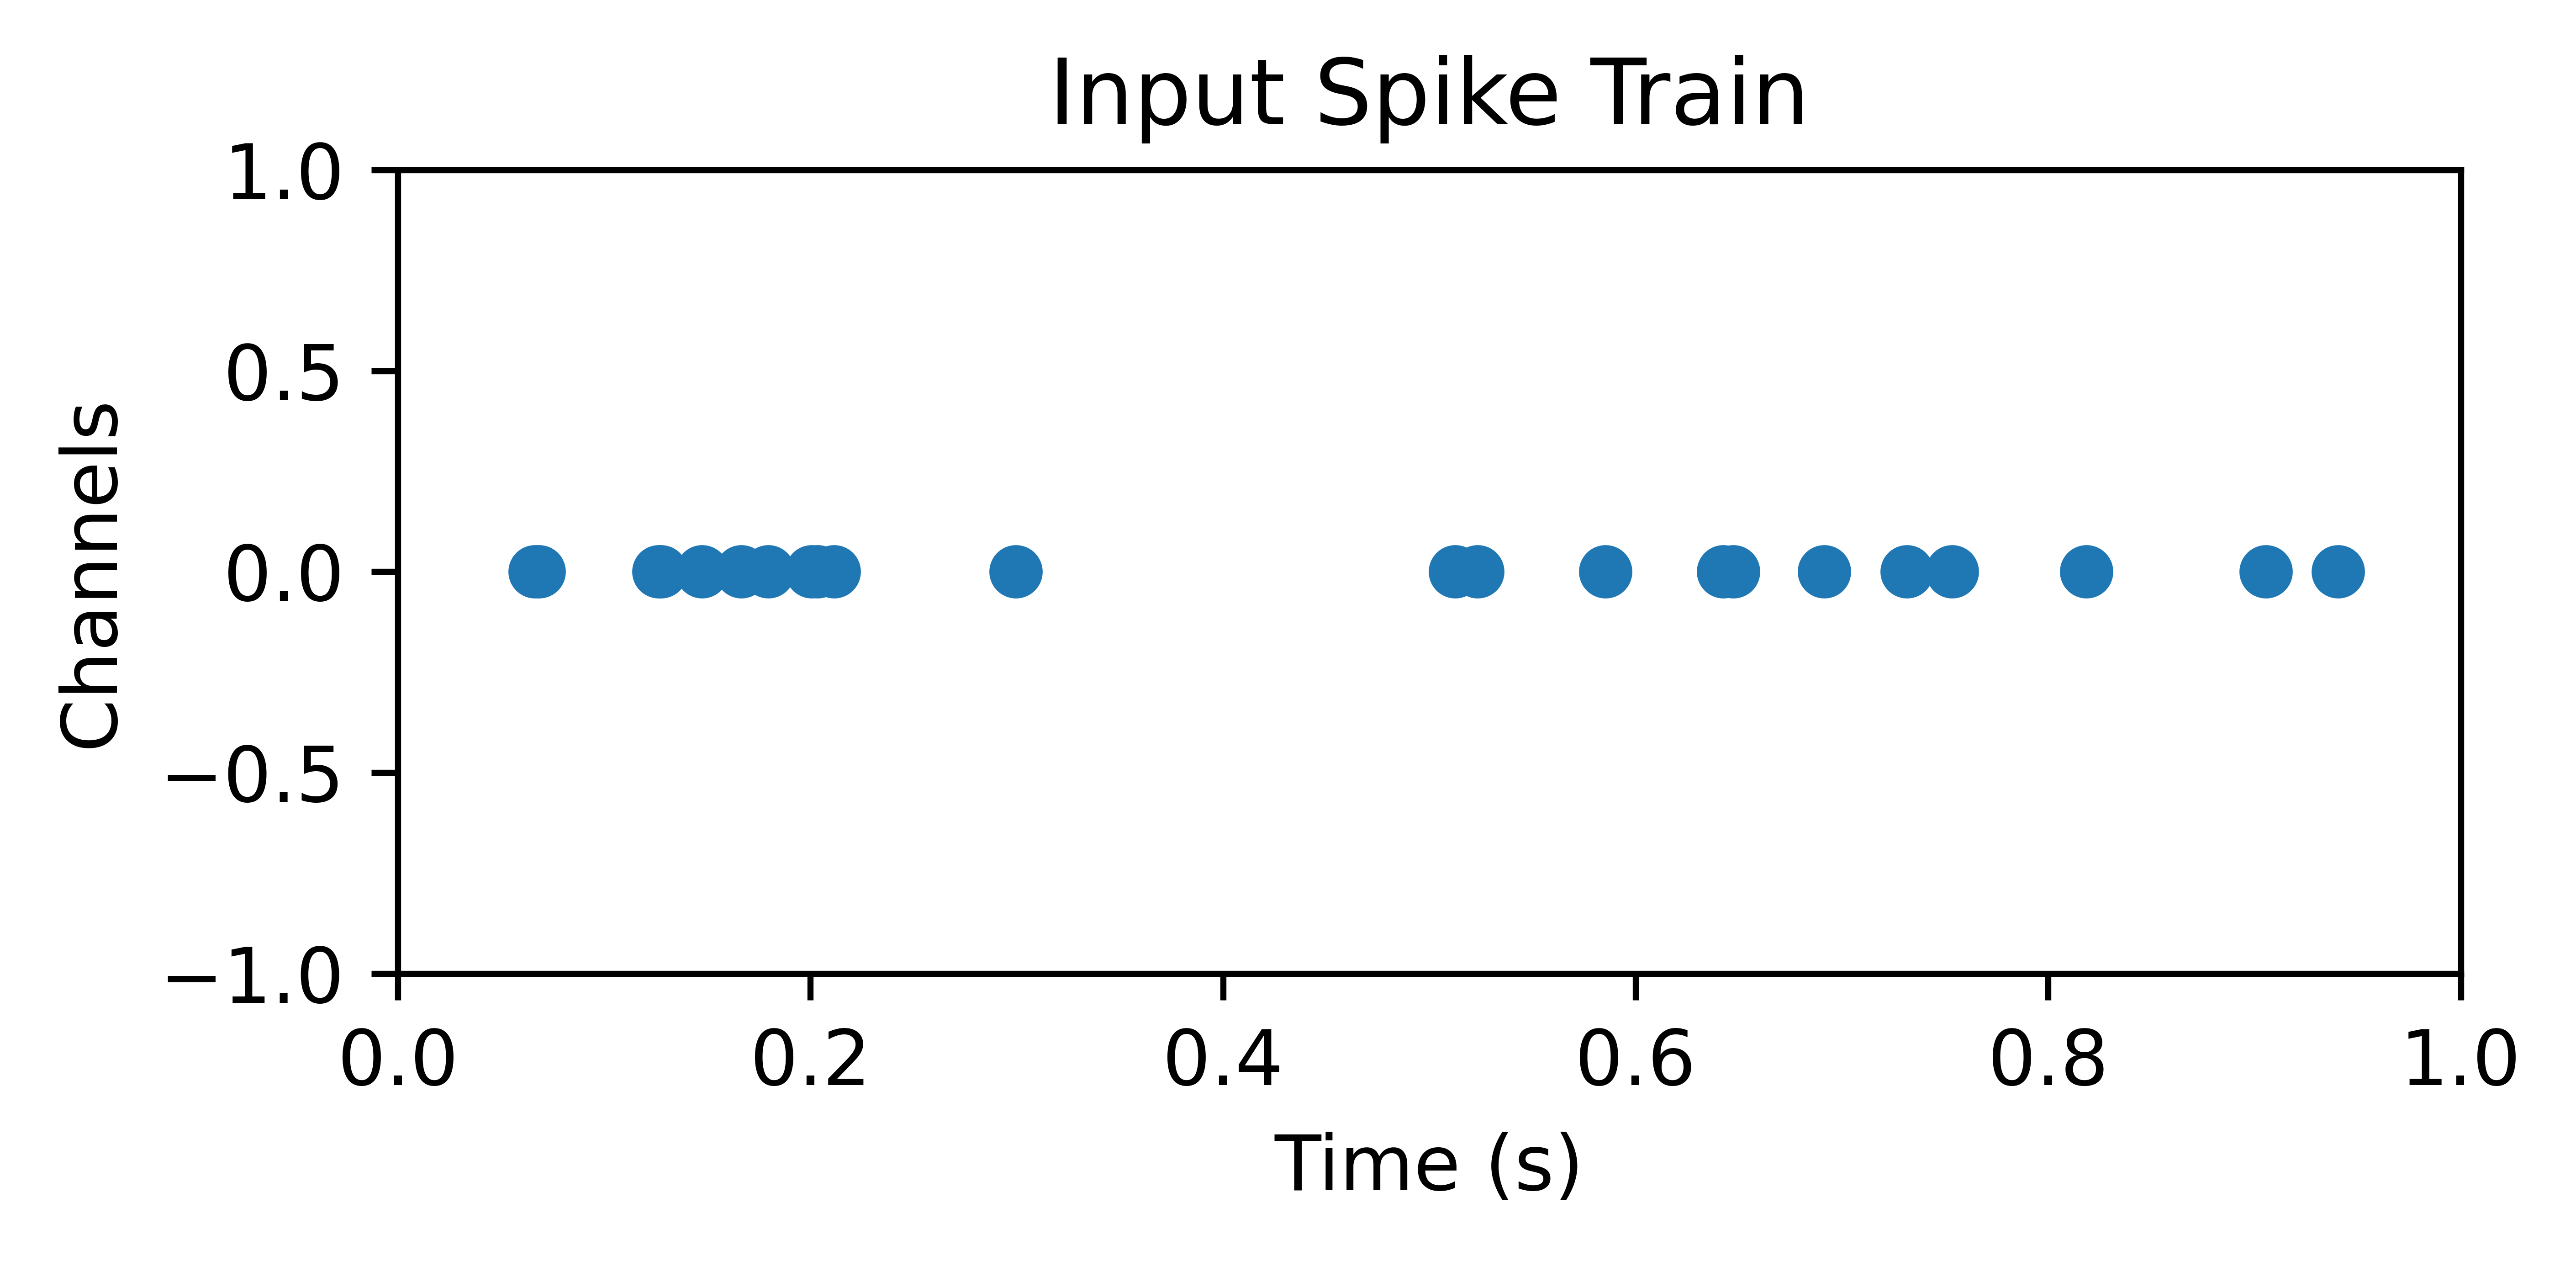

In [10]:
dt = 1e-3
spike_raster = poisson_spike_train(
    n_channels=1, duration=1.0, rate=20.0, dt=dt, seed=2022
).astype(bool)
spike_ts_in = TSEvent.from_raster(spike_raster[0], dt=dt, name="Input Spike Train")
spike_ts_in.plot()
plt.tight_layout()


### Step 3 : Run

Simulate the network while recording the intermediate steps

In [11]:
model.reset_state()
out, state, record_dict = model(spike_raster, record=True)


### Step 4 : Analyze the results

Get the synapse and membrane responses from the record dictionary, plot the figure.

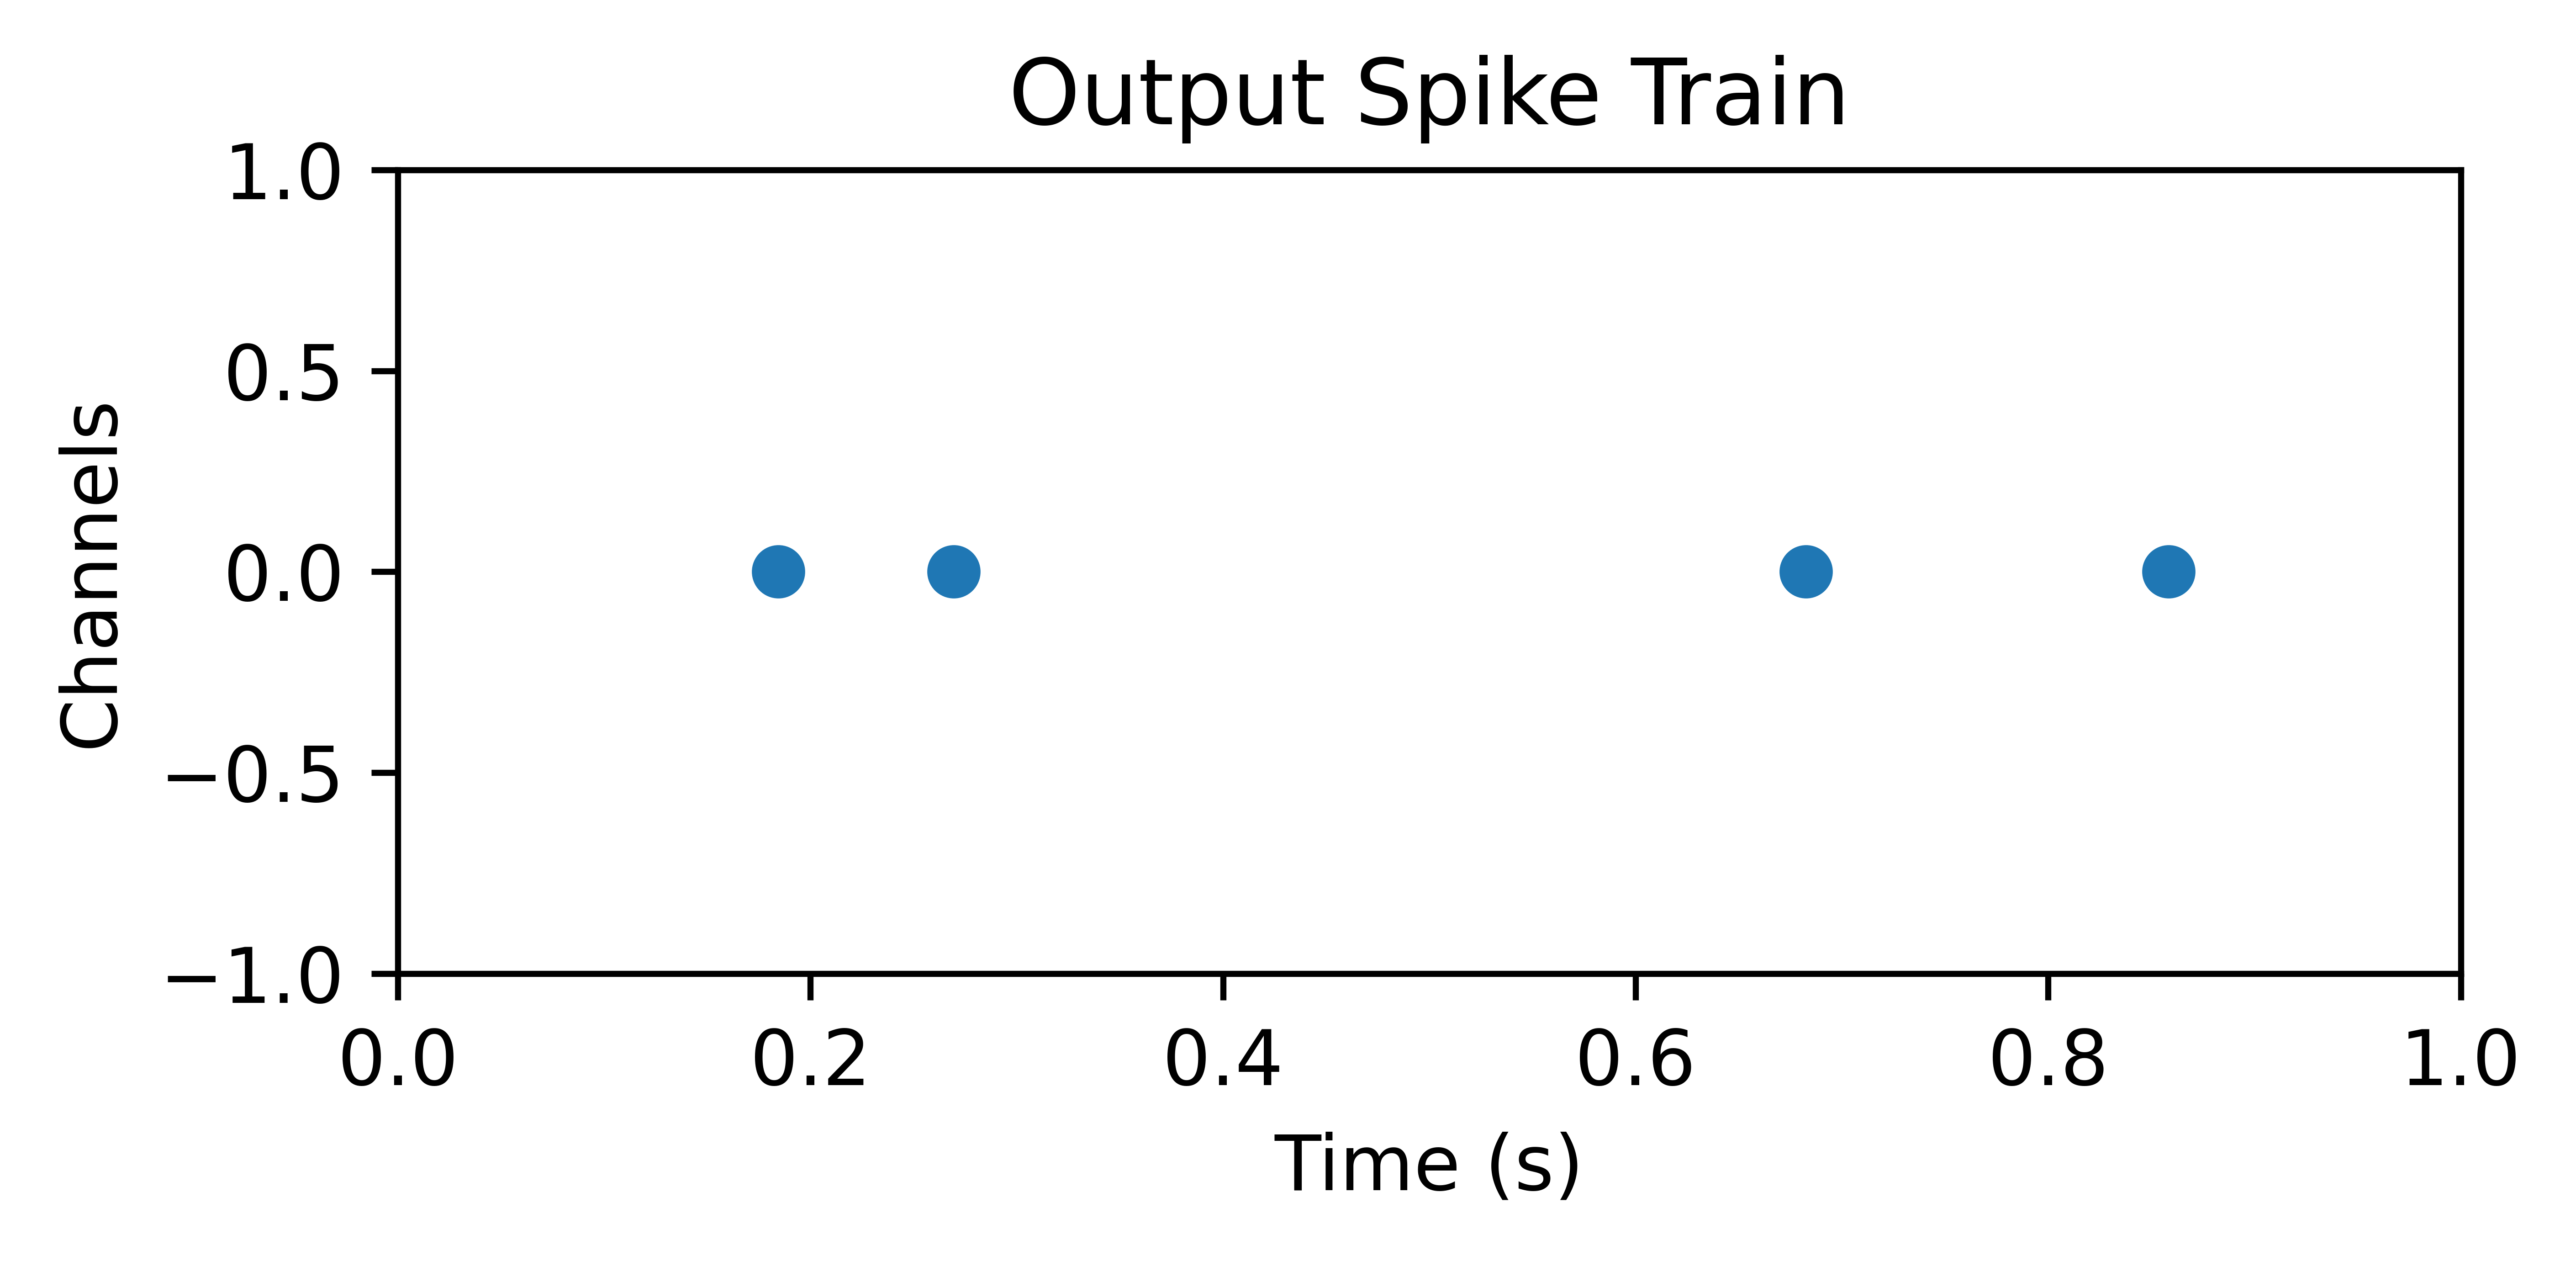

In [12]:
spike_ts_out = TSEvent.from_raster(out[0], dt=dt, name="Output Spike Train")
spike_ts_out.plot()
plt.tight_layout()


Plot the membrane potential reading and synaptic injection current on the figure.

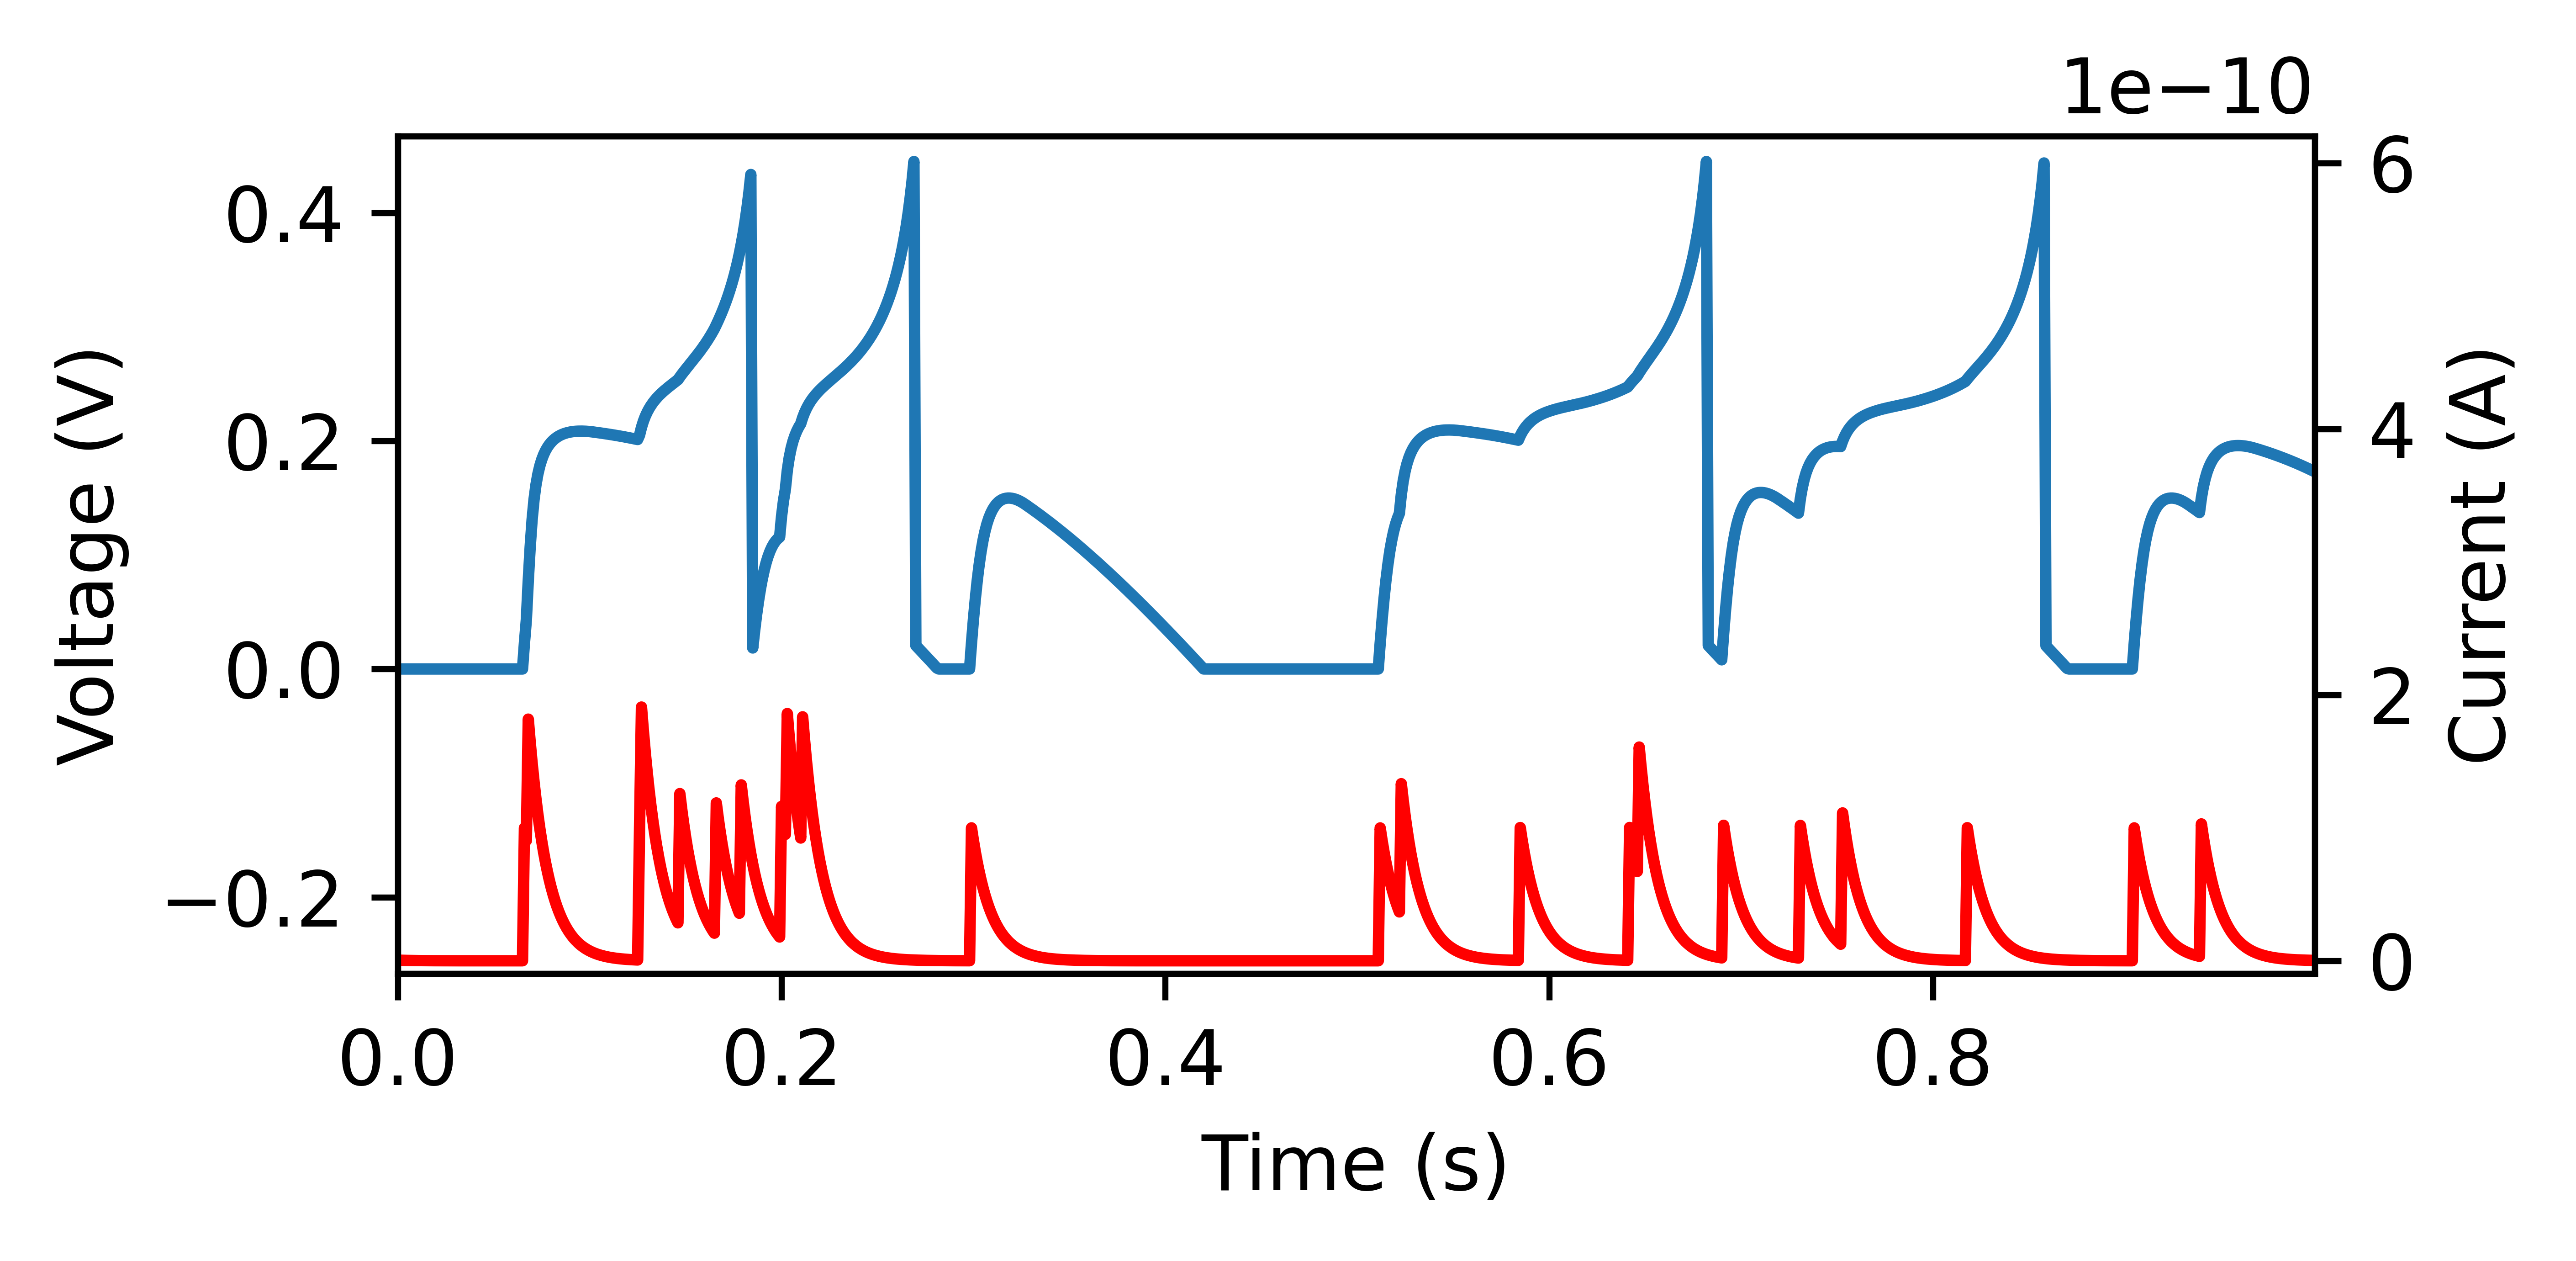

In [13]:
# Plot the vmem and isyn on the same figure
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plot_Ix(
    record_dict["1_DynapSim"]["vmem"][0],
    ylabel="Voltage (V)",
    ax=ax1,
    label="$V_{mem}$",
)
plot_Ix(record_dict["1_DynapSim"]["isyn"][0], ax=ax2, color="red", label="$I_{syn}$")
split_yaxis(ax1, ax2, (2, 1))
plt.tight_layout()


At first glance, the response is similar to the response of the Leaky Integrate and Fire neuron response presented in the simple introduction tutorial.
Indeed, with small disparities, they are pretty close to each other.
In both cases, the synaptic current instantly increases when a spike arrives and leaks consistently.
One significant difference in DPI response is the short-term facilitation; the jump amount depends on the synaptic state.
If the current value $I_{syn}$ is sufficiently greater than $I_{gain}$, the jump is more prominent, and else it's depressed.

Also, we can see the effect of positive feedback circuitry that the more the membrane capacitor is charged, the bigger the jumps we observe.

For this specific execution, the layout parameters: capacitance, thermal voltage, and subthreshold slope factor, are all kept at their default values.
The default values of the parameters provide a smooth operation region.

## Section 3 : Spike Generation Logic

Remember that the common feature of every spiking neuron is declared as that they hold the temporal state information and produce a spike when the state threshold constraints are satisfied.
As a computatioanl neuron model, the Dynap-SE neuron synapse simulation block, stores the temporal state in $I_{mem}$ current and compare the $I_{mem}$ current with spike threshold current $I_{spkthr}$ to produce a spike.
However, the naive implementation of this conditional logic makes it troublesome to optimize a spiking neural network using gradient based optimization mechanisms.
Instead, a Heaviside-step function with custom gradient rules is implemented to decide on spike generation at each time step.


In [14]:
%psource step_pwl

@custom_jvp
def step_pwl(
    imem: jnp.DeviceArray,
    Ispkthr: jnp.DeviceArray,
    Ireset: jnp.DeviceArray,
    max_spikes_per_dt: int = jnp.inf,
) -> float:
    """
    step_pwl implements heaviside step function with piece-wise linear derivative to use as spike-generation surrogate

    :param imem: Input current to be compared for firing
    :type imem: jnp.DeviceArray
    :param Ispkthr: Spiking threshold current in Amperes
    :type Ispkthr: jnp.DeviceArray
    :param Ireset: Reset current after spike generation in Amperes
    :type Ireset: jnp.DeviceArray
    :return: number of spikes produced
    :rtype: float
    """
    spikes = jnp.ceil(jnp.log(imem / Ispkthr))
    n_spikes = jnp.clip(spikes, 0.0, max_spikes_per_dt)
    return n_spikes


### Section 3.1 Set the parameters

Spiking threshold current and reset current

In [15]:
# Currents in Amperes
Ispkthr = 1e-6
Ireset = 5e-13


### Section 3.2 Scan the Parameter Space

Generate a logaritmic space and record the output of the spike generation function `step_pwl` at each time step

In [16]:
Imem_space = np.logspace(start=-14, stop=-3, num=10000)
n_spikes_trace = [step_pwl(Imem, Ispkthr, Ireset) for Imem in Imem_space]


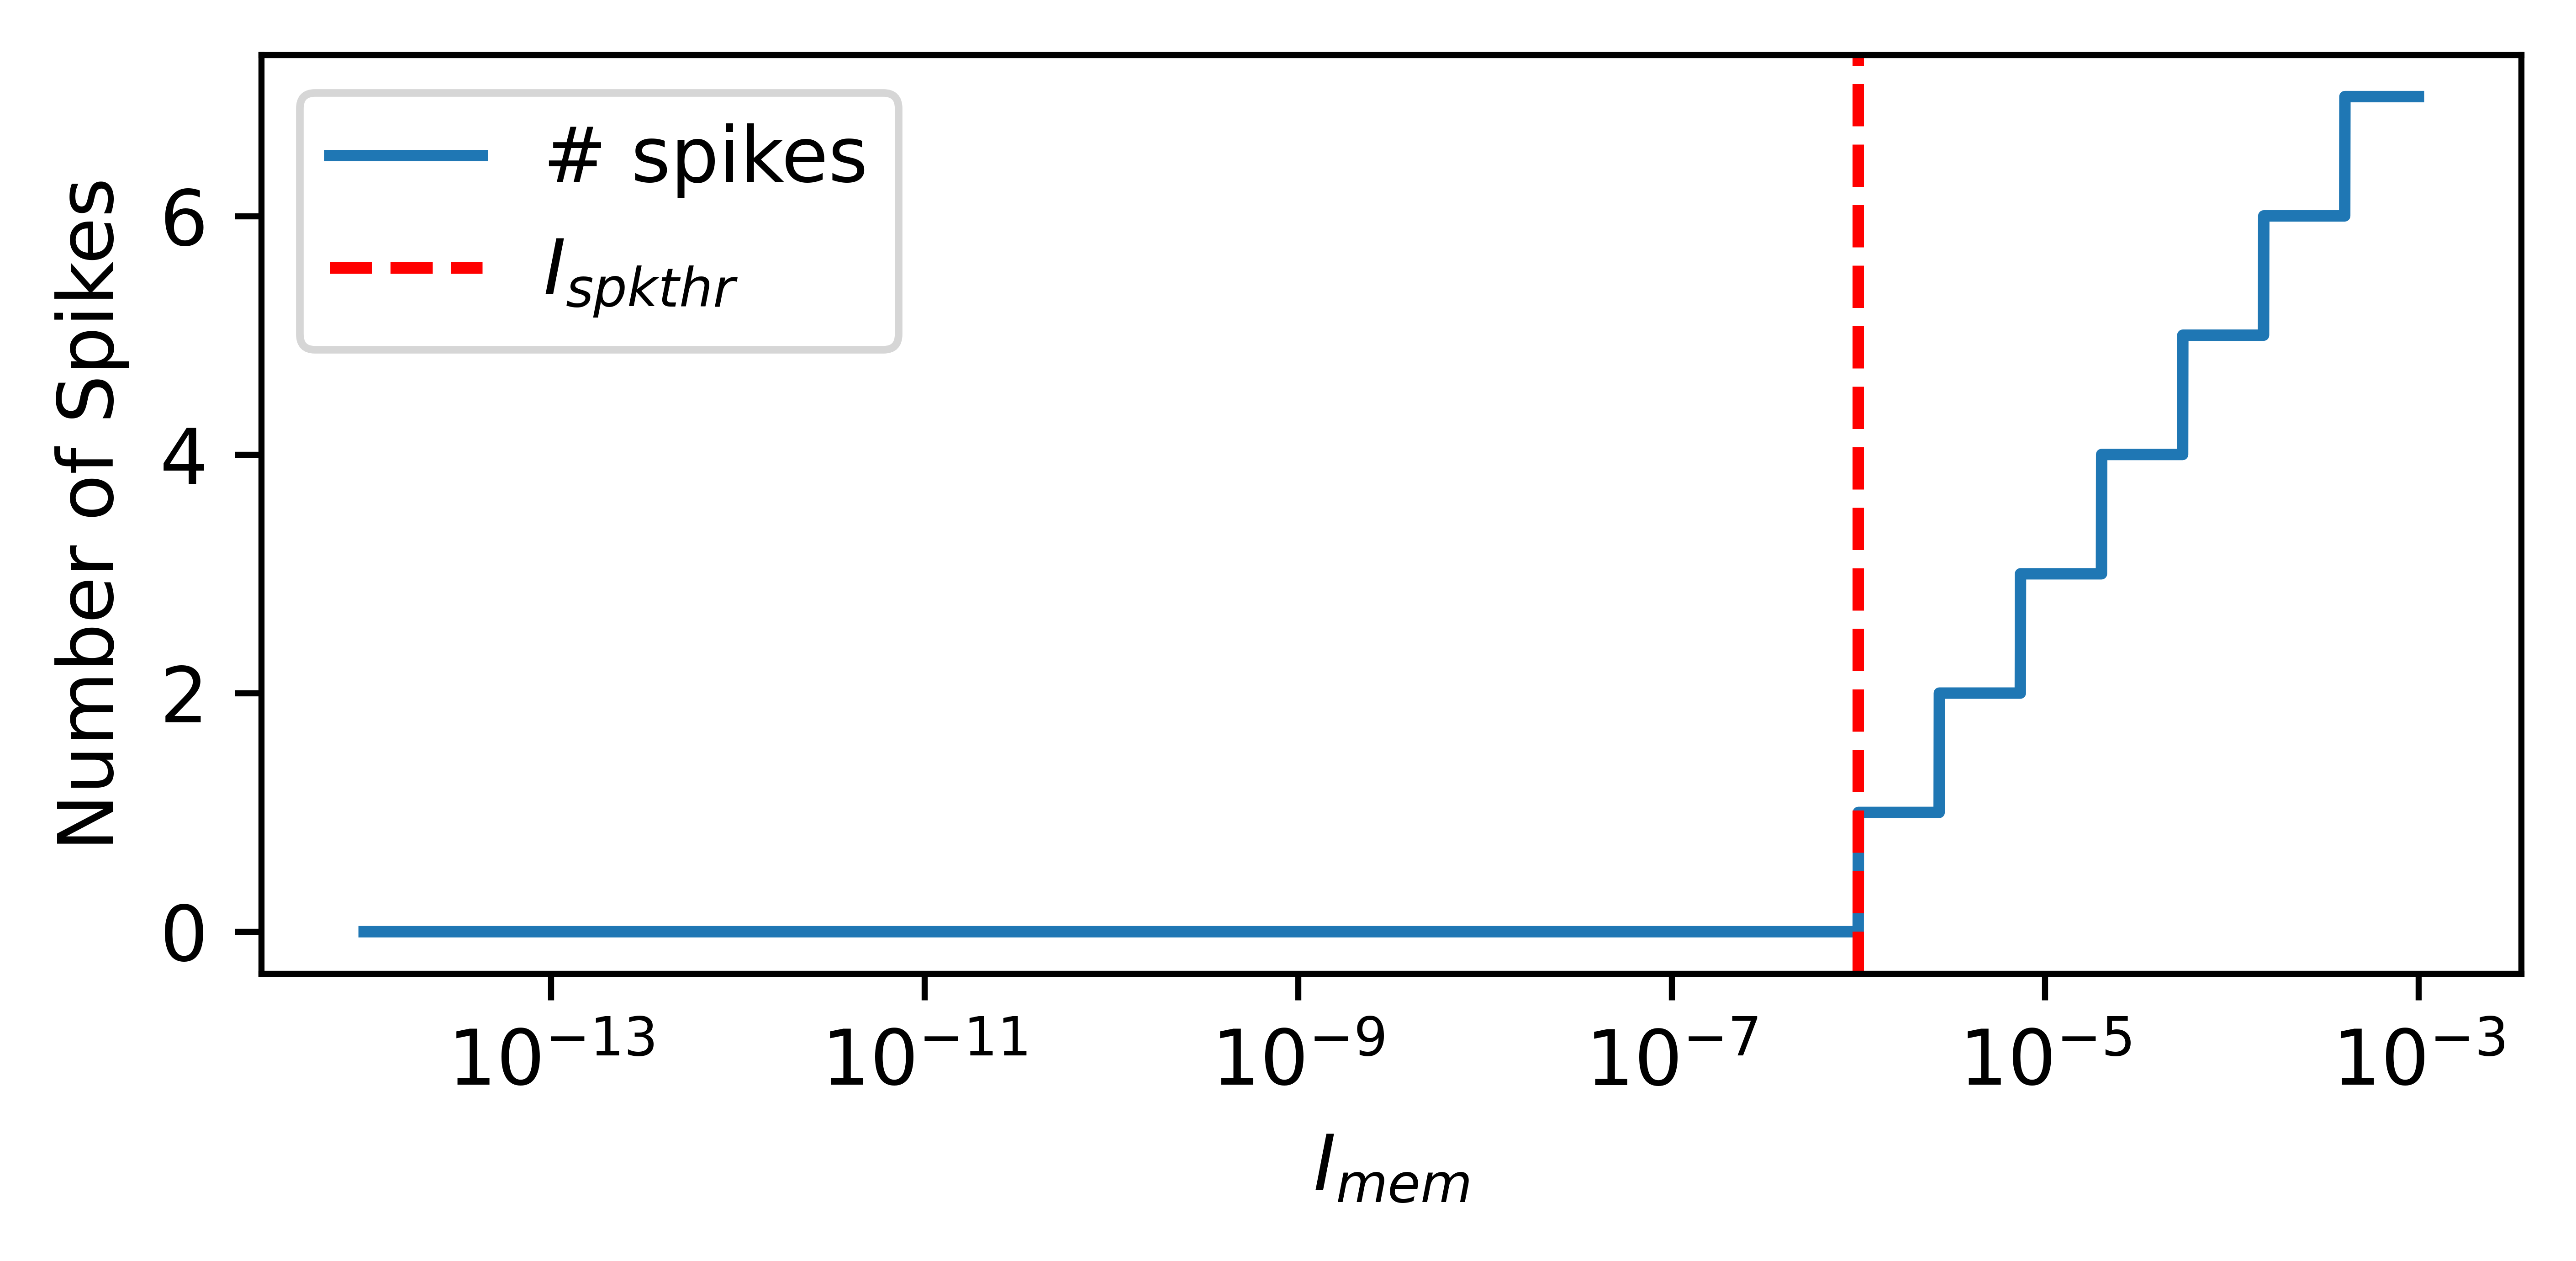

In [17]:
# Plotting
fig = plt.figure()
plt.semilogx(Imem_space, n_spikes_trace, label="# spikes")
plt.axvline(Ispkthr, linestyle="dashed", color="red", label="$I_{spkthr}$")

# Labeling
plt.xlabel("$I_{mem}$")
plt.ylabel("Number of Spikes")
plt.legend()
plt.tight_layout()


The x axis represents the membrane current and the y axis represents the number of spikes produced.
The actual circuit produces a spike comparing the membrane potential $V_{mem}$ and the spike threshold parameter set $V_{spkthr}$.
So, although it's physically not possible, if $V_{mem}$ doubles the $V_{spkthr}$ then two spikes at the same time would have to be produced.
In the simulation, there is no harm to go beyond the physical limitations being aware the consequences.
Easing off the restrictions makes a broader parameter space visible.
The physical reality could be compelled using regularization techniques when necessary.

In the subthreshold operation region, the relation between current values and respective base voltages is exponential.
Therefore, doubling the potential corresponds to squaring the current.
Respecting this, the step-function that is implemented requires that the current should be one order of magnitude higher than the spike threshold current in order for multi-spike production.
Accordingly, the waveform provided in Figure \ref{fig:threshold} resembles a linear staircase in the log-scaling.
The exact equation producing this thresholding mechanism is given in Equation \ref{eq:spike_threshold}.

$$
    \text{num\_spikes} = \left \lceil{\ln \left(\dfrac{I_{mem}}{I_{spkthr}}  \right)}\right \rceil
$$


## Section 4 : Surrogate Gradient Function

Although the functionality introduced up to this point is sufficient to build and execute spiking neural networks using the Dynap-SE neuron model, it's not enough to optimize a network efficiently.
In order to run a gradient-based optimization algorithm, this neuron model requires a surrogate function.

Check these references for more about surrogate gradient approach:

* J. Lee, T. Delbrück, and M. Pfeiffer. Training deep spiking neural networks using backpropagation. Frontiers in Neuroscience, 10, 2016
* E. O. Neftci, H. Mostafa, and F. Zenke. Surrogate gradient learning in spiking neural networks: Bringing the power of gradient-based optimization to spiking neural networks. IEEE Signal Processing Magazine, 36(6):51–63, 2019
  
Broadly speaking, it addresses the problem that the spiking neurons deliver discrete outputs using an indifferentiable threshold function, which makes it impossible to backpropagate the error.
In the conventional backpropagation approach, the chain rule is applied for error credit assignment.
In spiking neurons, the output is a spike train and backpropagating the error to previous layer requires taking the derivative of the threshold function.
In Dynap-SE neuron implementation, taking the derivative of the output spike train with respect to a parameter that specify the membrane current dynamics looks like the following.

$$
    \dfrac{\partial S_{out}(t)}{\partial P} = \dfrac{\partial \Theta (I_{mem}, I_{spkthr})}{\partial I_{mem}} \cdot \dfrac{\partial I_{mem}}{\partial P}
$$

Here, $\Theta$ stands for the Heaviside step function, and the parameter P can be anything that changes the membrane dynamics like a leakage current, or a gain current, and etc.
In order to find how a small fraction of change in the parameter $P$ affects the output spike train, the $\Theta$ function should be differentiable.
However, the derivative of the spike generation function is almost always zero since the surface is mostly flat.
When the derivative is not zero, it's infinite because of the sudden jumps.
As a solution, an approximate continuous function that is able to substitute the exact spike generation function is used as a surrogate in the backward pass.
Implementation of the custom gradient rule is given below.

In [18]:
from rockpool.devices.dynapse.simulation.surrogate import step_pwl_jvp
%psource step_pwl_jvp

@step_pwl.defjvp
def step_pwl_jvp(
    primals: Tuple[jnp.DeviceArray], tangents: Tuple[jnp.DeviceArray]
) -> Tuple[jnp.DeviceArray]:
    """
    step_pwl_jvp custom jvp function defining the custom gradient rule of the step pwl function

    :param primals: the primary variables passed as the input to the `step_pwl` function
    :type primals: Tuple[jnp.DeviceArray]
    :param tangents: the first order gradient values of the primal variables
    :type tangents: Tuple[jnp.DeviceArray]
    :return: modified forward pass output and the gradient values
    :rtype: Tuple[jnp.DeviceArray]
    """
    imem, Ispkthr, Ireset, max_spikes_per_dt = primals
    imem_dot, Ispkthr_dot, Ireset_dot, max_spikes_per_dt_dot = tangents
    primal_out = step_pwl(*primals)
    tangent_out = jnp.clip(jnp.ceil(imem - Ireset), 0, 1) * imem_dot
    return primal_out, tangent_out


### Section 4.1 Gradient Compuation

Now, re-use the logaritmic space, but this time store the gradient of the step function `step_pwl` computed independently at each point in the parameter space.

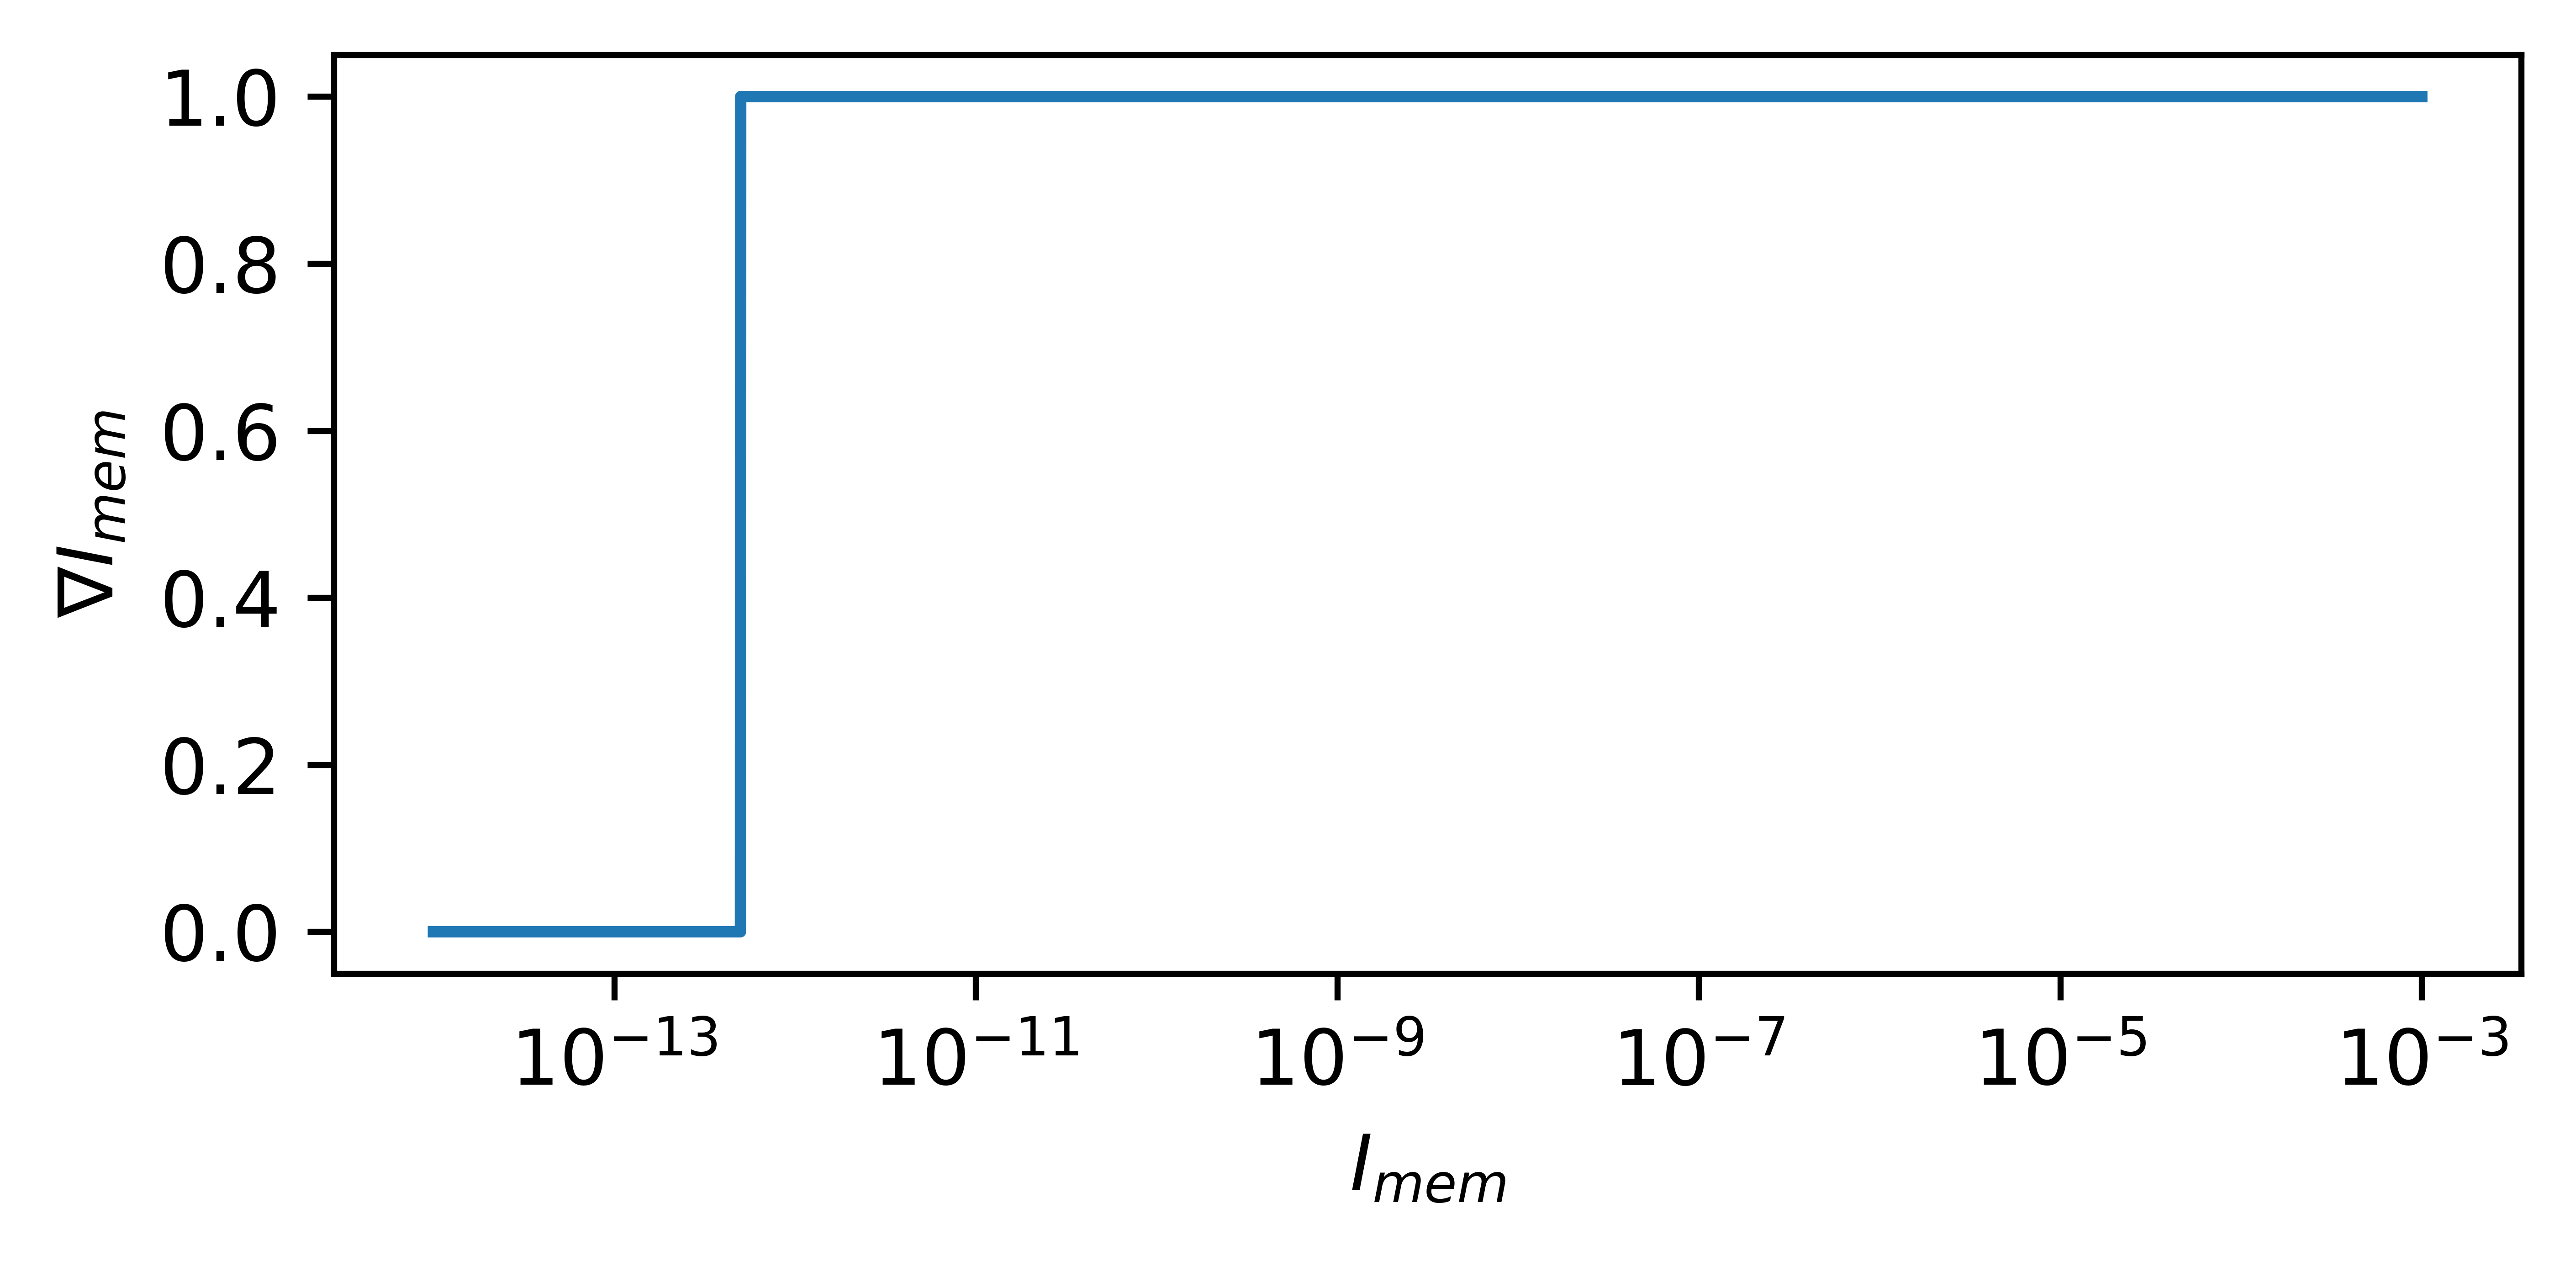

In [19]:
# Scan the parameter space
Imem_nabla = [jax.grad(step_pwl)(Imem, Ispkthr, Ireset) for Imem in Imem_space]

# Plot
fig = plt.figure()
plt.xlabel("$I_{mem}$")
plt.ylabel("$ \\nabla I_{mem}$")
plt.semilogx(Imem_space, Imem_nabla)
plt.tight_layout()


The gradient value is equal to 1 provided that the $I_{mem}$ is greater than $I_{reset}$ value.
With this properly scaled gradient, backpropagation or any other gradient based method can be applied to computational Dynap-SE neuron model.

Note that, having a constant value above a threshold, the surrogate function resembles the gradient of the famous `ReLU` function :).

### Section 4.2 : Restoring Surrogate Function

Computing the integral of the gradient values, restores the surrogate function. Since only the custom gradient implemented, that is the only way to visualize the behavior of the virtual backward pass function. 

In [20]:
# Integrate
diff_space = np.diff(np.concatenate(([Imem_space[0] / 2], Imem_space)))
surrogate = np.cumsum(np.array(Imem_nabla) * diff_space)


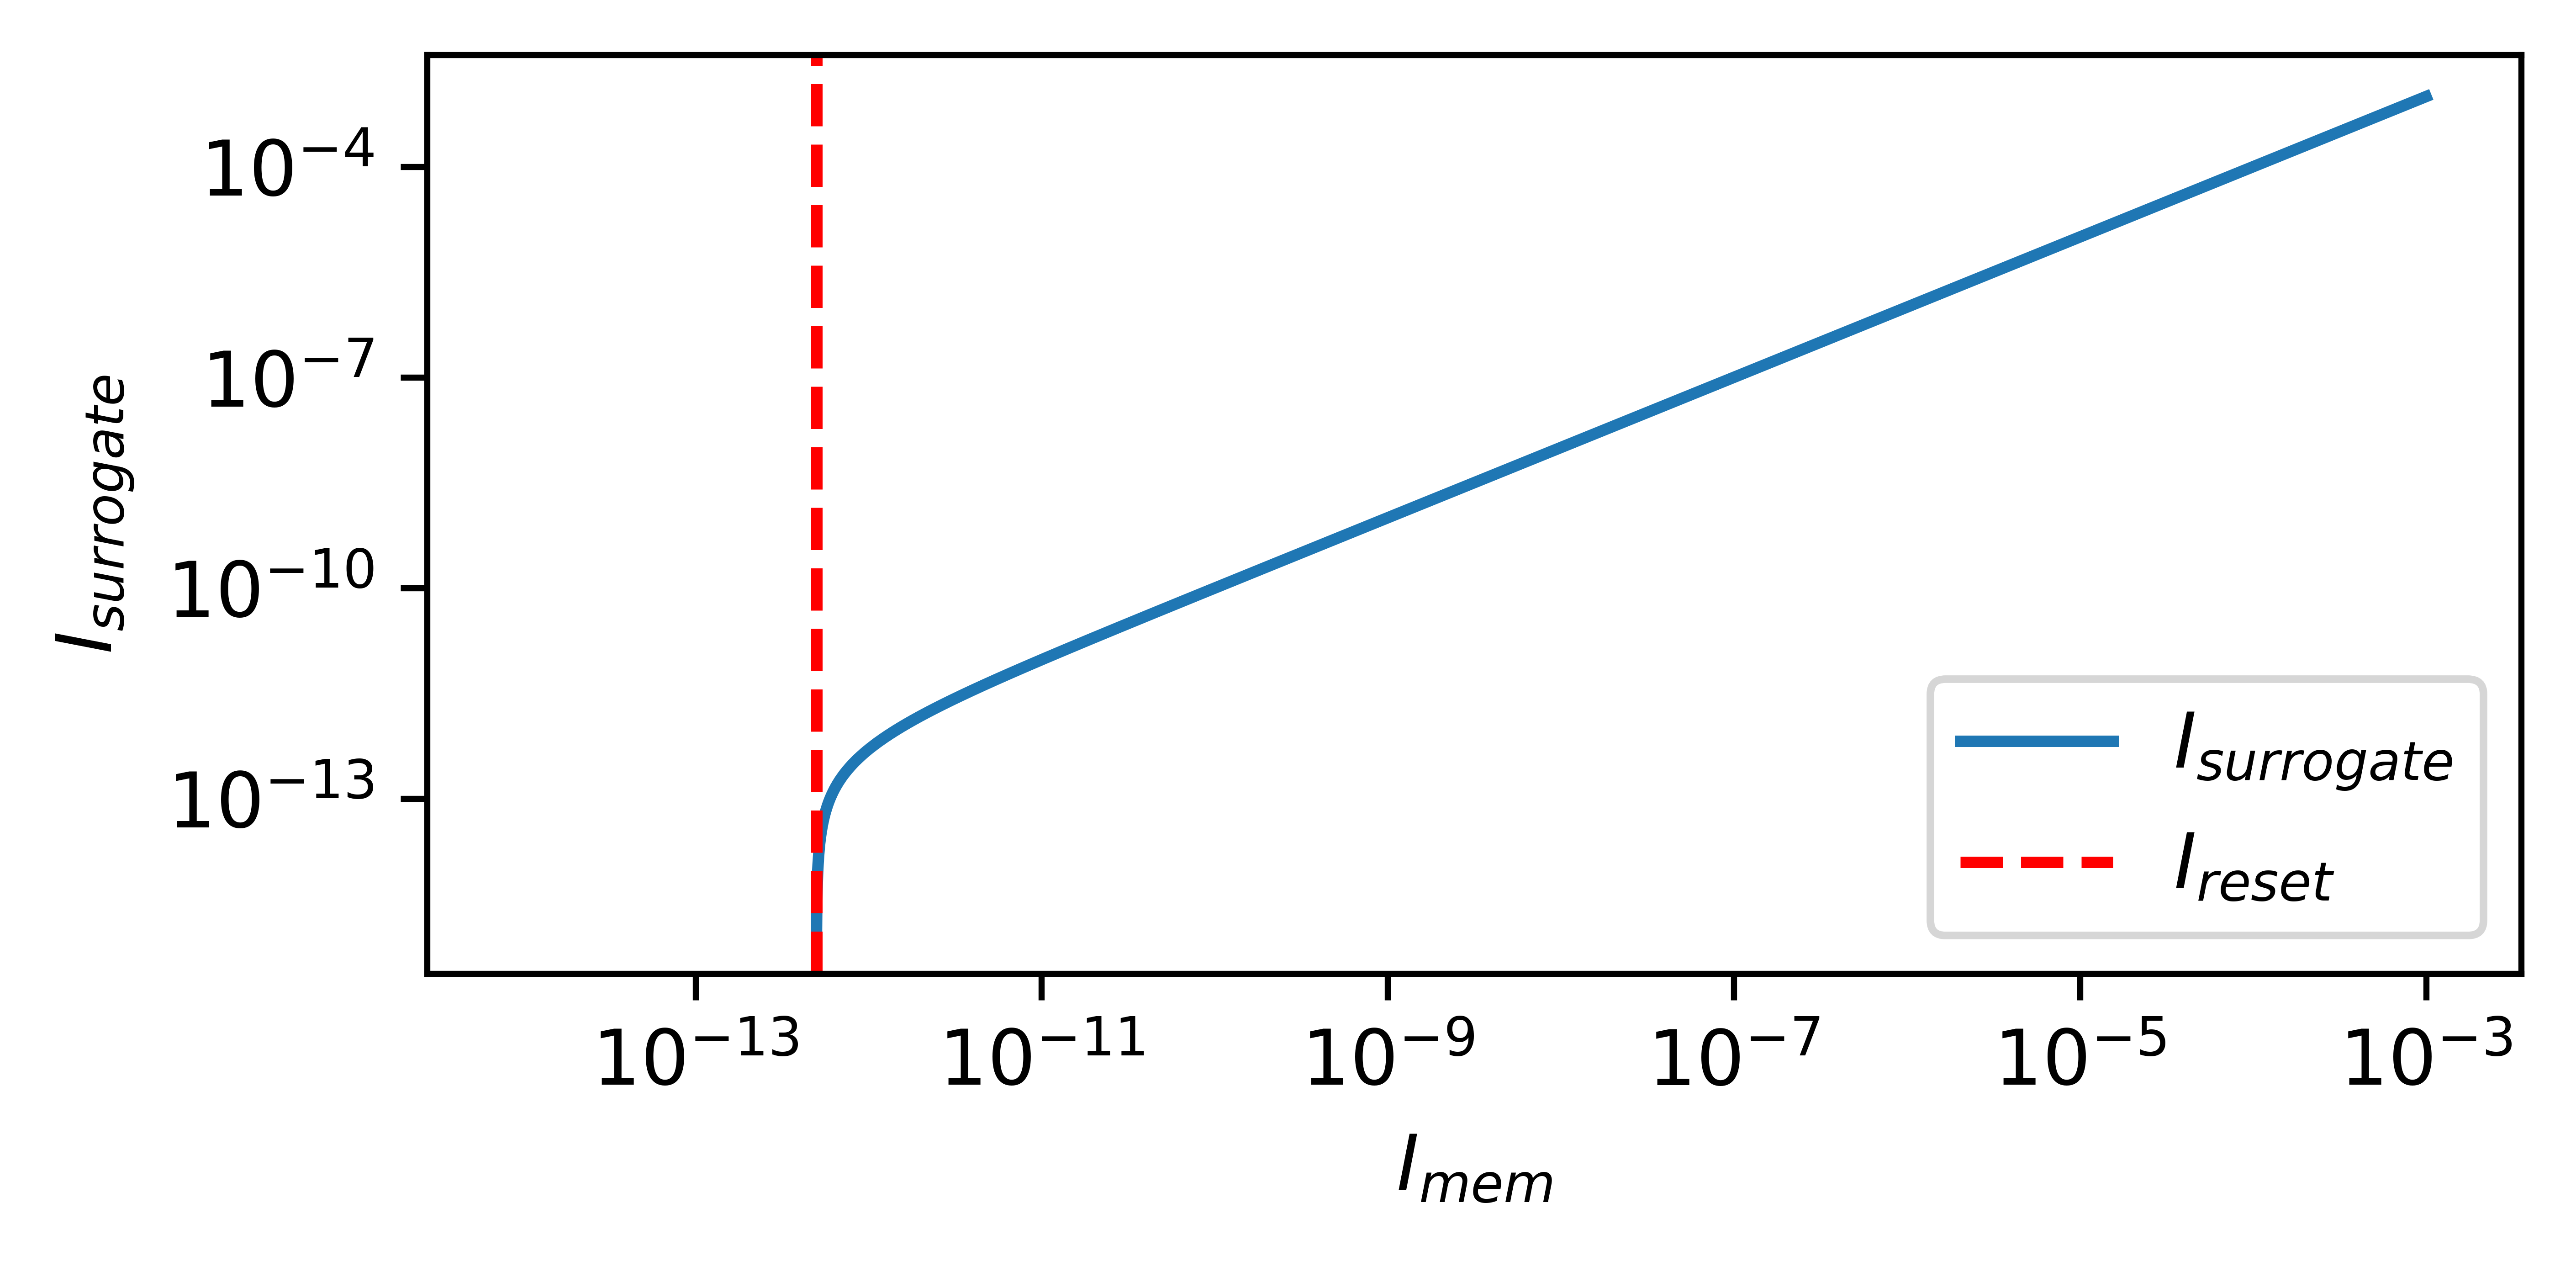

In [21]:
# Plot
fig = plt.figure()
plt.loglog(Imem_space, surrogate, label="$I_{surrogate}$")
plt.axvline(Ireset, linestyle="dashed", color="red", label="$I_{reset}$")

# Label
plt.xlabel("$I_{mem}$")
plt.ylabel("$I_{surrogate}$")
plt.legend()
plt.tight_layout()


In the surrogate counterpart, again the x axis represents the membrane current, but the y axis here is not the number of spikes.
Instead, the waveform seen can be regarded as a smoothed out version of the staircase outlook of the actual function.
Also, in order to ensure that the membrane current is differentiable in the full operation range, the cut-off value is not $I_{spkthr}$, but it's $I_{reset}$.

## Next Steps

The following tutorials will cover network optimization, and post-optimization stages required to deploy a network succesfully to the device.